## Train multiple brian-style networks to generate 2 sines at different frequencies
    - Each BS network (brian-style) will be trained to produce a different number of latents and with different amounts of noise
    - compare the effects of dU on each.

In [1]:
# import stuff
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.fft import fft,fftfreq
import datetime
import scipy
import pickle

### Load the factors that we want the BS network to produce

In [90]:
# path to saved network
savePath = '/Users/andrew/Documents/GitHub/basal_ganglia/data/projectionsFromTrainedNetwork/2023-08-29 13_40_23.npy'

# load
data = np.load(savePath,allow_pickle=True)
data = data.ravel()[0]

# parse the data
proj     = data['projections']
inputs   = data['inputs']
numConds = data['numConds']
targets  = data['targets']


#### For now, I only want my network to produce a single condition.
    - pull out only the activity from condition 1


In [10]:
# pull out the projections from condition 1
proj_rs = proj.reshape(-1,2,proj.shape[1],order='F')
proj = proj_rs[:,0,:]

# run PCA again to order projections by variance accounted for
pca = PCA(n_components=proj.shape[1])
proj = pca.fit_transform(proj)

### make lists of the number of latents and noise levels for training

In [87]:
numZ = list(np.arange(2,10))
noiseScale = [0, 1e-8, 1e-6, 1e-4, 1e-2]
numNetworks = len(numZ) * len(noiseScale)

### define the parameters for the networks

In [54]:
### Train W weights using RLS ###
# fix W_in (taken from the rate model above), choose U randomly

## define a few parameters ##

# network time constant (in msec)
tau = 10

# gain for U weights
g_U = 0.1

# U weights are drawn from a uniform distribution. Set range of this distribution
uMin = -1
uMax = 1

# gain for the input weights
g_W_in = 0.1


# gain for J0 weights. We want these to be fairly small.
g_j0 = 0.5

# gain for initial W weights
g_w  = 0.025

# initial learning rate
alpha = 1

## draw our U and J0 weights ##

# number of neurons
numN = 200

# J0
J0 = np.random.normal(loc=0, scale=(g_j0**2)/(numN * tau**2), size=(numN,numN))

# W_in
W_in = np.random.uniform(low=uMin,high=uMax, size=(numN,1)) * g_W_in

## rename our inputs ##
INPUT = np.copy(inputs)

## number of trials to train ##
numTrials = 25

## trial duration ##
trlDur = proj.shape[0]


## initial state, x0 ##
x0 = np.random.normal(loc=0, scale=1,size=(numN,1)) / np.sqrt(numN)

## initial rate, r0 ##
r0 = np.zeros((numN,1))


In [57]:
# function for training networks
def trainNetwork(num_z,noise_scale):

    # define our target latents, Z
    Z_target = proj[:,:num_z]

    # add a dimension for backwards compatibility
    Z_target = Z_target[:,:,np.newaxis]


    # define our U
    u = np.random.uniform(low=uMin,high=uMax, size=(num_z,numN)) * g_U

    # initialize W
    w = np.random.normal(loc=0,scale=1/(numN * g_w),size=(numN,num_z))

    # initial latents, z0
    z0 = np.zeros((num_z,1))

    # initial value of P
    P = np.eye(numN) / alpha

    ### cycle through trials ###

    # initialize an array to hold output
    networkOutput = np.zeros((trlDur,num_z,1,numTrials))

    for trl in range(numTrials):

        # cycle through conditions
        for cc in range(1):

            # set the initial state, rate, and latent
            x = np.copy(x0)
            r = np.copy(r0)
            z = np.copy(z0)

            # cycle through the trial
            for ii in range(trlDur):

                # update our state
                x += (1/tau) * (-x + (J0.T@r) + (u.T@z) + (INPUT[ii,cc] * W_in)
                                + np.random.normal(loc = 0, scale = np.sqrt(noise_scale), size = x.shape))

                # calculate our current rate
                r = np.tanh(x)

                # calculate the current z
                z = w.T@r

                # save the output
                networkOutput[ii,:,cc,trl] = z[:,0]

                # calculate the error
                error = np.atleast_2d(z[:,0] - Z_target[ii,:,cc])

                # update the weights
                w = w - ((P @ r)@error)

                # update P
                P = P - ((P @ r @ r.T @ P)/(1 + (r.T @ P @ r)))

    # return trained weights
    return w, networkOutput, u


In [58]:
# cycle through networks and train
counter=0

# initialize list to hold trained W's and U's
W = []
U = []

# and the network outputs
outputs = []

for zz in numZ:
    for nn in noiseScale:
        counter+=1
        print('training network ' + str(counter))
        tempW,tempOut,tempU = trainNetwork(zz,nn)
        W.append(tempW)
        U.append(tempU)
        outputs.append(tempOut)


training network 1
training network 2
training network 3
training network 4
training network 5
training network 6
training network 7
training network 8
training network 9
training network 10
training network 11
training network 12
training network 13
training network 14
training network 15
training network 16
training network 17
training network 18
training network 19
training network 20
training network 21
training network 22
training network 23
training network 24
training network 25
training network 26
training network 27
training network 28
training network 29
training network 30
training network 31
training network 32
training network 33
training network 34
training network 35
training network 36
training network 37
training network 38
training network 39
training network 40


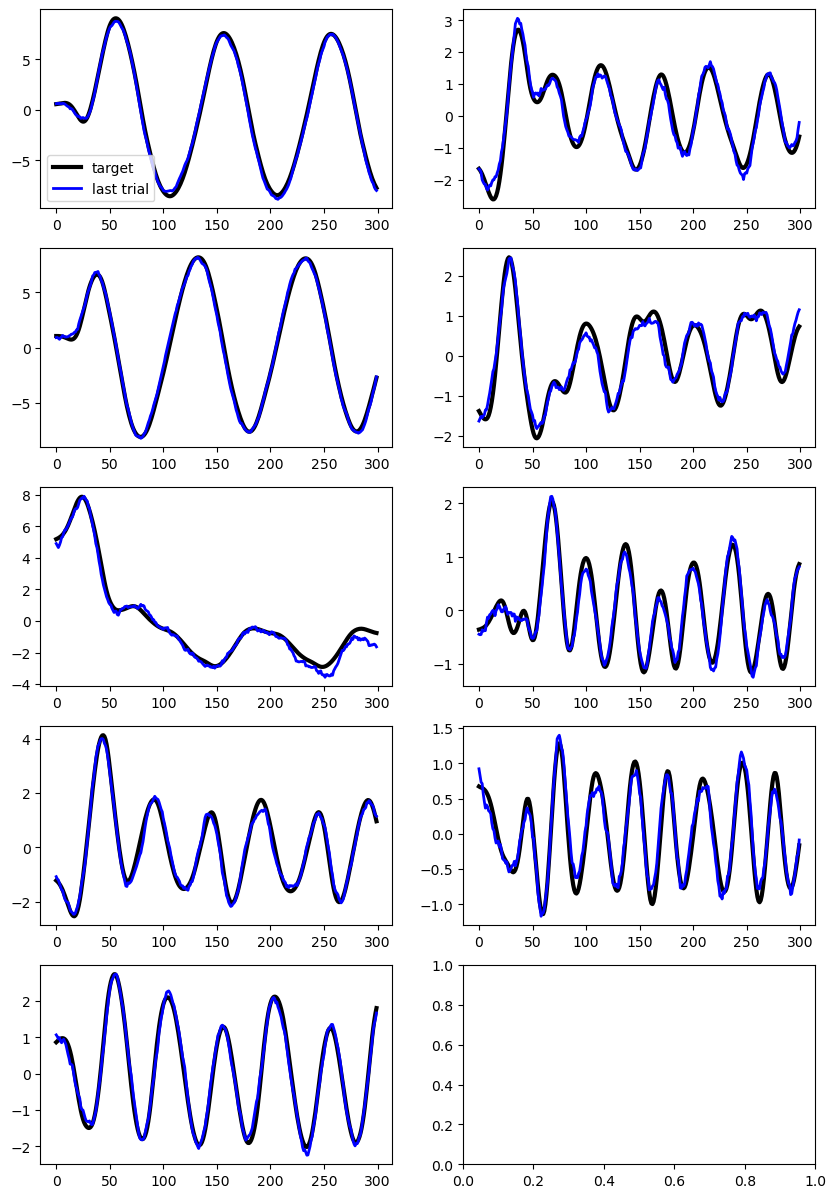

In [68]:
# check training performance for a few networks

# pull out the target
Z_target_rs = proj[:,:,np.newaxis]

# pull out the network output
networkOutput = outputs[-1]

# number of latents for this network
numZ = networkOutput.shape[1]

# plot the first and last trial (along with the target)
numRows = 5
fig, ax = plt.subplots(numRows,2, figsize = (10,15))

# only plot one condition
cond = 0

for ii in range(numZ):

    # get the row and column index
    rIdx = np.mod(ii,numRows)
    cIdx = (ii//numRows)

    # plot the target
    ax[rIdx,cIdx].plot(Z_target_rs[:,ii,cond],'k',linewidth=3,label='target');

    # plot the last trial
    ax[rIdx,cIdx].plot(networkOutput[:,ii,cond,-1],'b',linewidth=2,label='last trial')


    if ii==0:
        ax[rIdx,cIdx].legend()


### Plug in a B for each network
    - B will allow us to readout the target (for the rate network) from the activity of the units
    - B will be orthogonal-ish to W

In [81]:
# function for getting the rates from the trained network
def returnRates(u,ipt,w,j0=J0,w_in=W_in,b=None):

    ## initialize arrays to track rates and (if we are given a b) output of the network ##

    # useful numbers
    trlDuration, numConds = ipt.shape
    numLatents,numUnits = u.shape

    # initialize our matrices
    allRates   = np.zeros((trlDuration, numConds, numUnits))
    allLatents = np.zeros((trlDuration, numConds, numLatents))
    allOutputs = np.zeros((trlDuration,numConds))


    # cycle through conditions
    for cc in range(numConds):

        # set the inital states/rates/Z
        x = np.copy(x0)
        r = np.copy(r0)
        z = np.zeros((u.shape[0],1))

        # cycle through time
        for ii in range(trlDuration):

            # update our state
            x += (1/tau) * (-x + (j0.T@r) + (u.T@z) + (ipt[ii,cc] * w_in))

            # calculate our current rate
            r = np.tanh(x)

            # calculate the current z
            z = w.T@r

            # save the rates
            allRates[ii,cc,:] = r[:,0]

            # save the latents
            allLatents[ii,cc,:] = z[:,0]

            # if we have an output vector, save network output
            if b is not None:
                allOutputs[ii,cc] = b.T@r

    # return output
    return allRates, allLatents, allOutputs

# variation on the function above.
# keep track of the 'perturbed' input to each neuron (Z * U) and the unperterbed input (Z * dU)
def returnRates_separateU(u,u_pert,ipt,w,j0=J0,w_in=W_in,b=None):

    ## initialize arrays to track rates and (if we are given a b) output of the network ##

    # useful numbers
    trlDuration, numConds = ipt.shape
    numLatents,numUnits = u.shape

    # initialize our matrices
    allRates     = np.zeros((trlDuration, numConds, numUnits))
    allLatents   = np.zeros((trlDuration, numConds, numLatents))
    allPertInput = np.zeros((trlDuration,numConds,numUnits,numLatents))
    allInput     = np.zeros((trlDuration,numConds,numUnits,numLatents))
    allOutputs   = np.zeros((trlDuration,numConds))


    # cycle through conditions
    for cc in range(numConds):

        # set the inital states/rates/Z
        x = np.copy(x0)
        r = np.copy(r0)
        z = np.copy(z0)

        # cycle through time
        for ii in range(trlDuration):

            # update our state
            x += (1/tau) * (-x + (j0.T@r) + (u.T@z) + (u_pert.T@z) + (ipt[ii,cc] * w_in))

            # calculate our current rate
            r = np.tanh(x)

            # calculate the current z
            z = w.T@r

            # save the rates
            allRates[ii,cc,:] = r[:,0]

            # save the latents
            allLatents[ii,cc,:] = z[:,0]

            # save the perturbed input
            allPertInput[ii,cc,:,:] = u_pert.T * z[:,0]

            # save the unperturbed input
            allInput[ii,cc,:,:] = u.T * z[:,0]

            # if we have an output vector, save network output
            if b is not None:
                allOutputs[ii,cc] = b.T@r

    # return output
    return allRates, allLatents, allOutputs, allInput, allPertInput

In [78]:
r,z,o = returnRates(u=U[-1],ipt=INPUT[:,0][:,np.newaxis],w=W[-1])

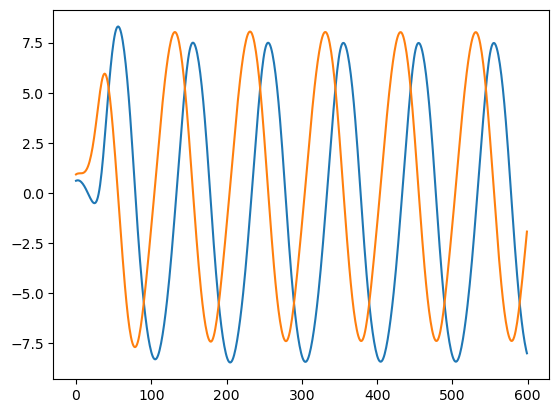

In [80]:
plt.plot(z[:,0,:2]);

In [103]:
INPUT[0,0]

1.0

/var/folders/h4/g8hnl8017b358kqbslb6bbx40000gn/T/ipykernel_22618/44269513.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(20,10))


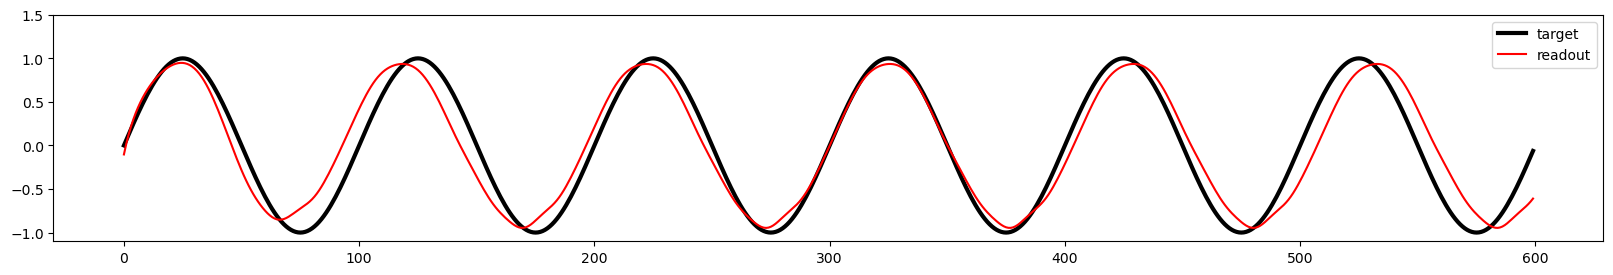

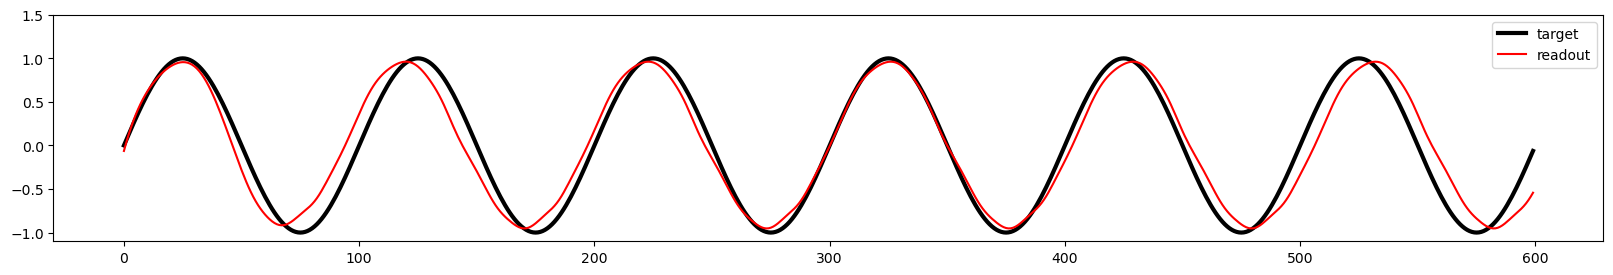

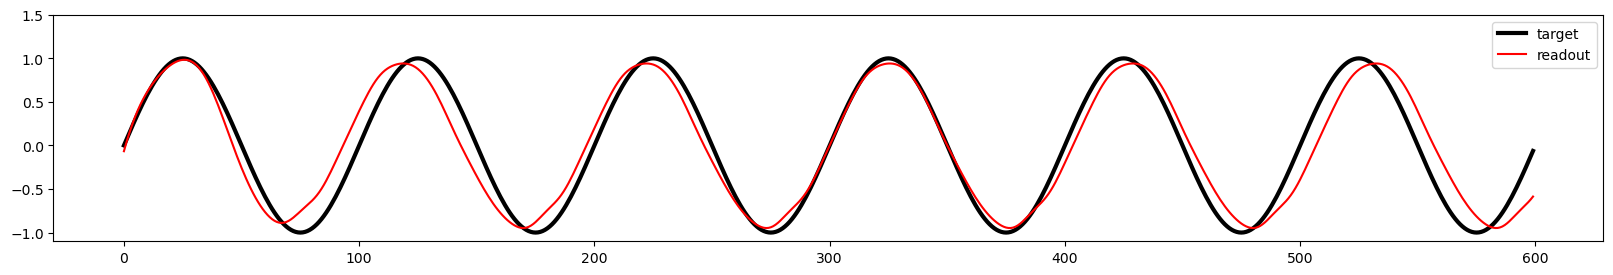

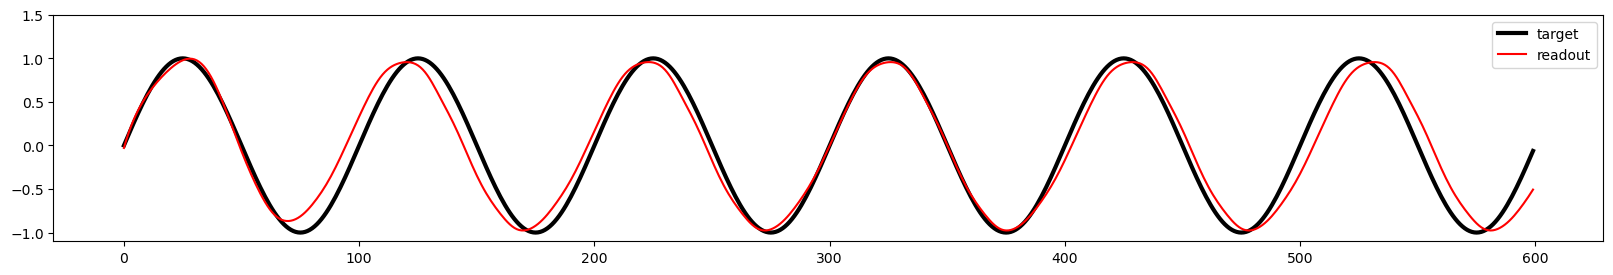

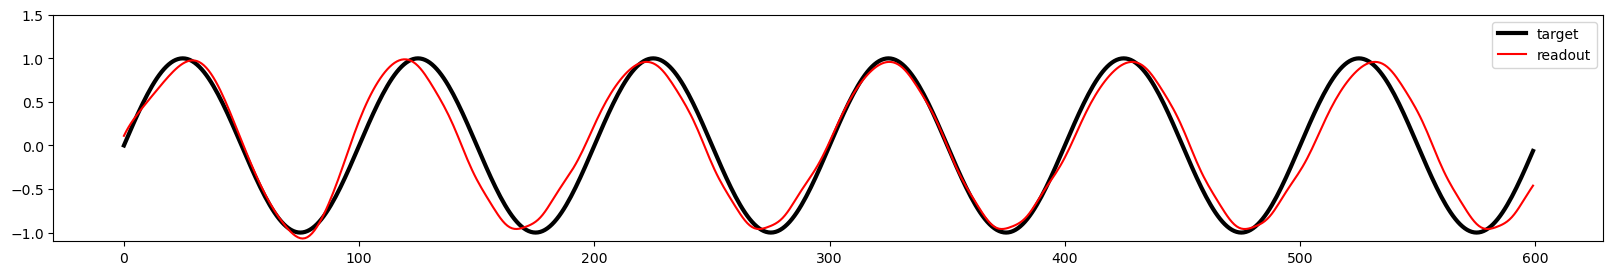

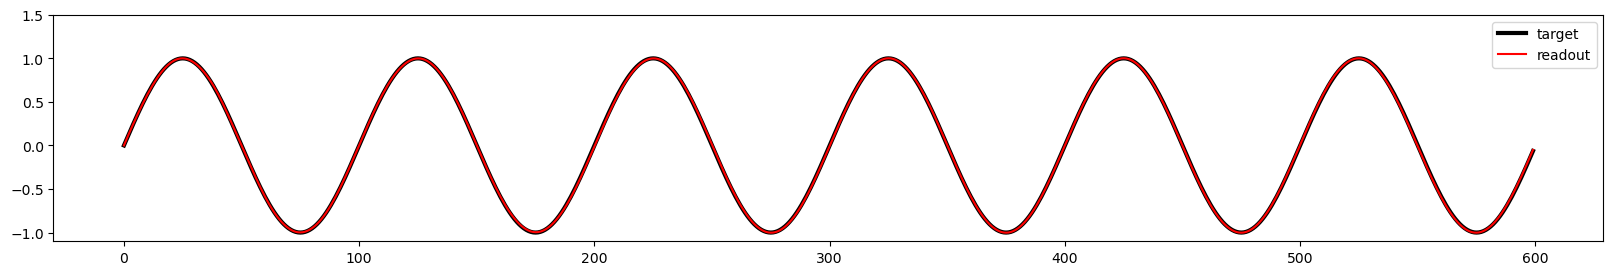

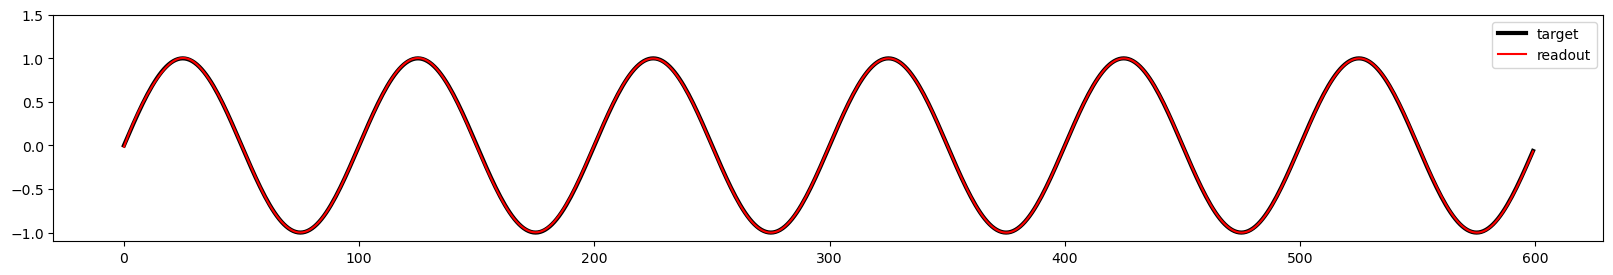

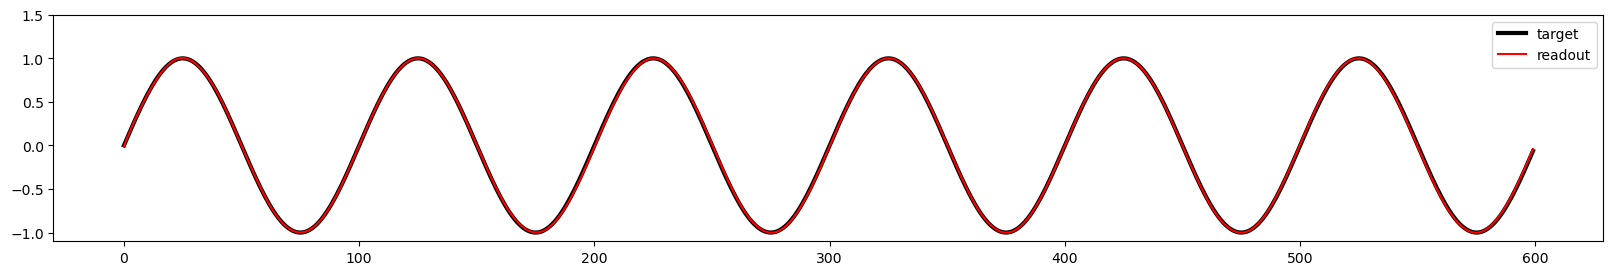

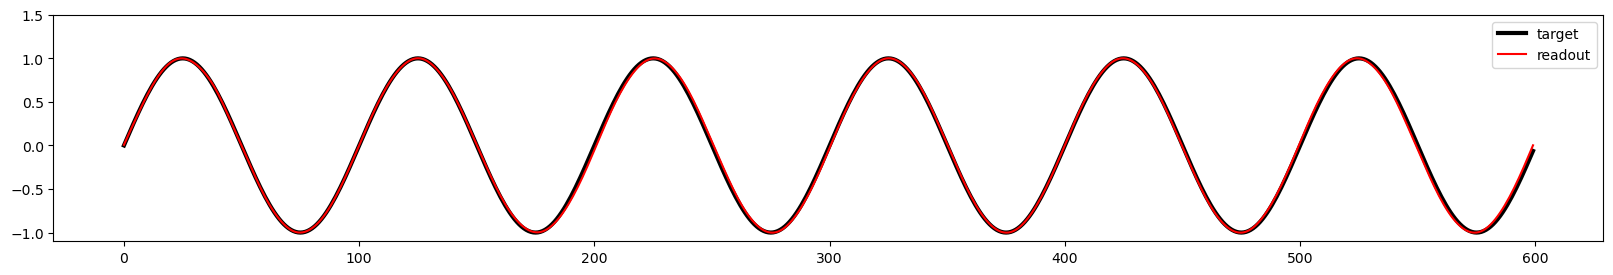

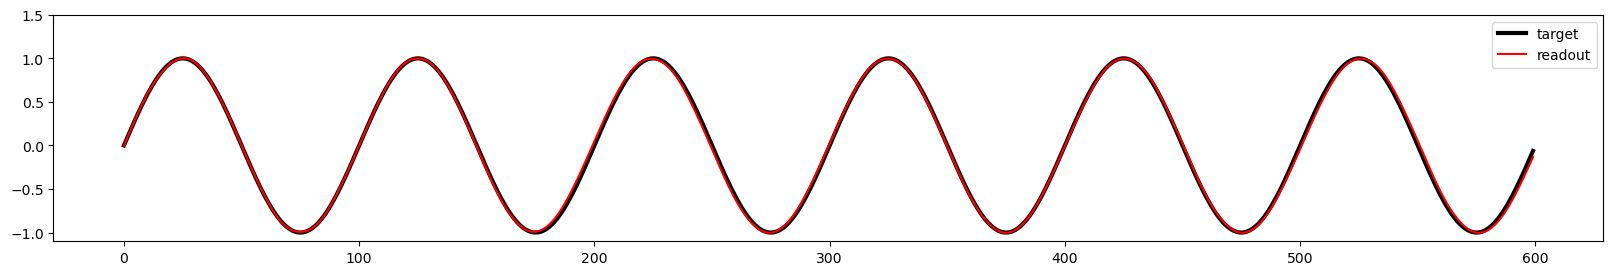

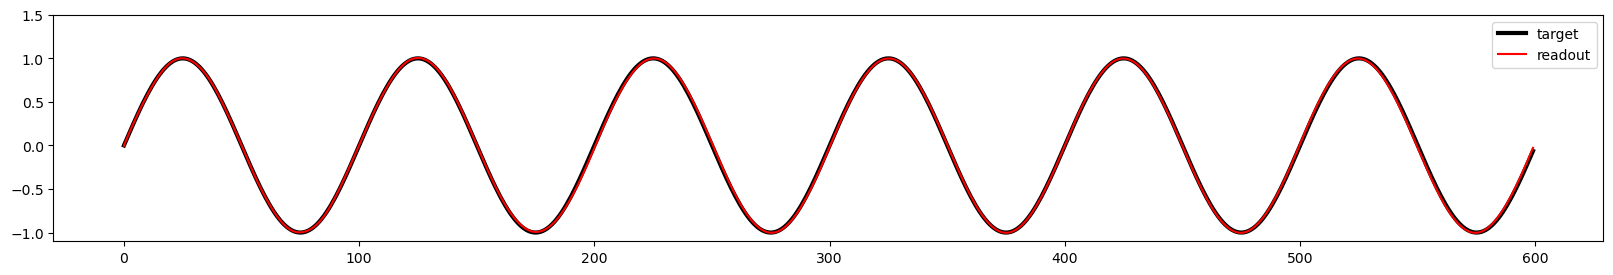

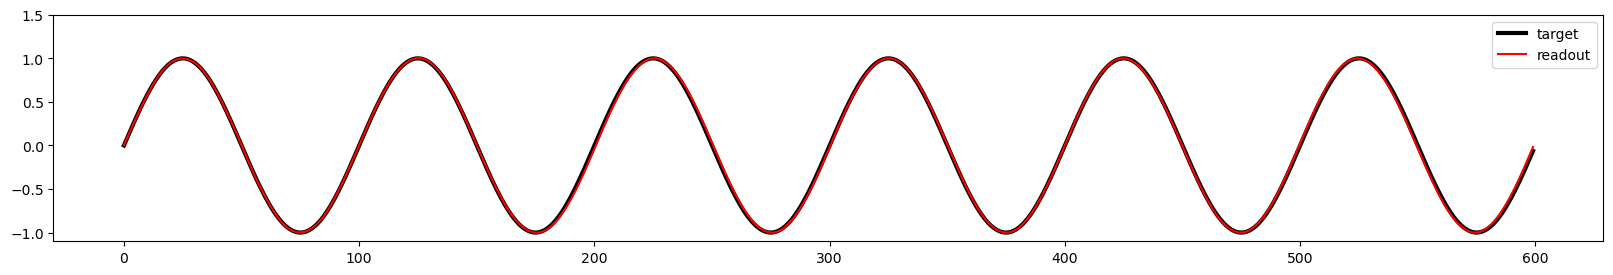

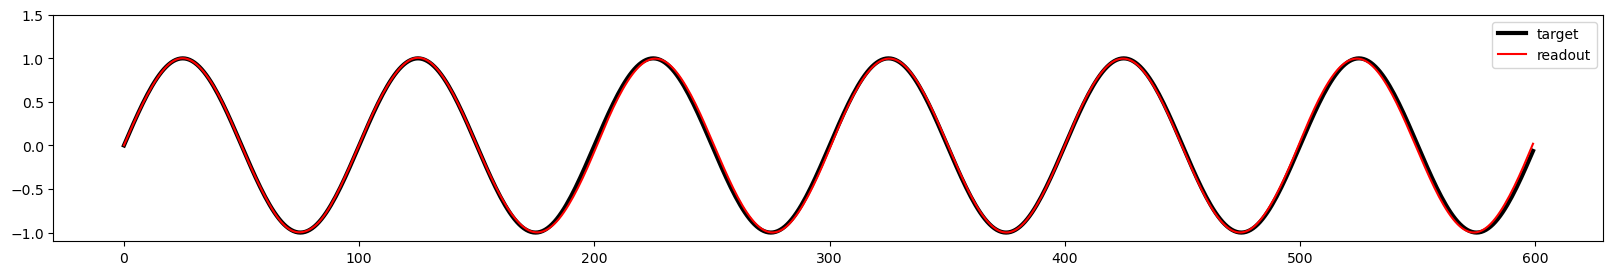

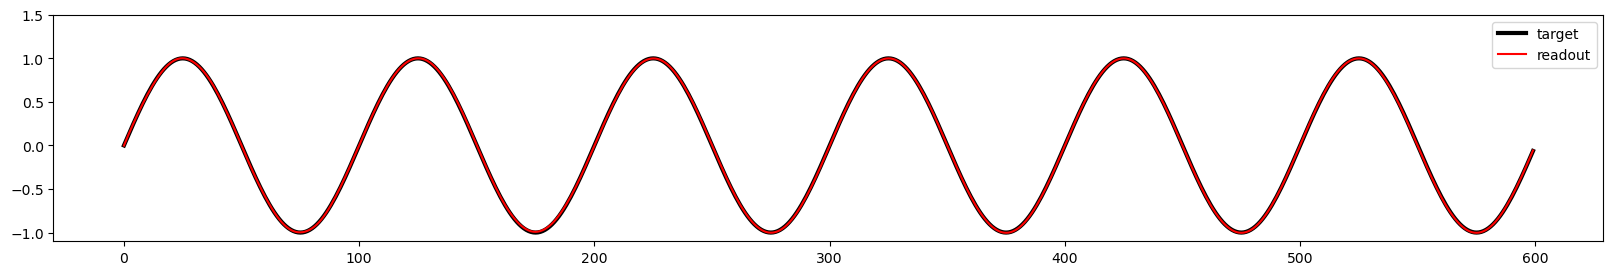

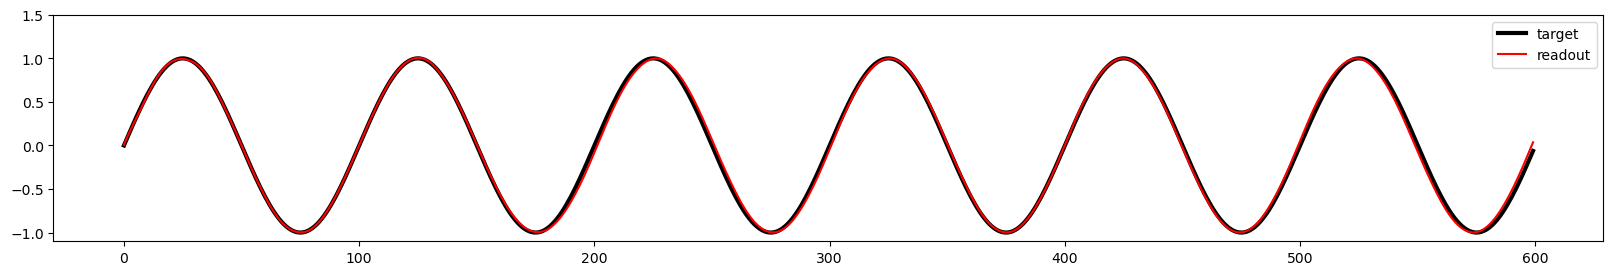

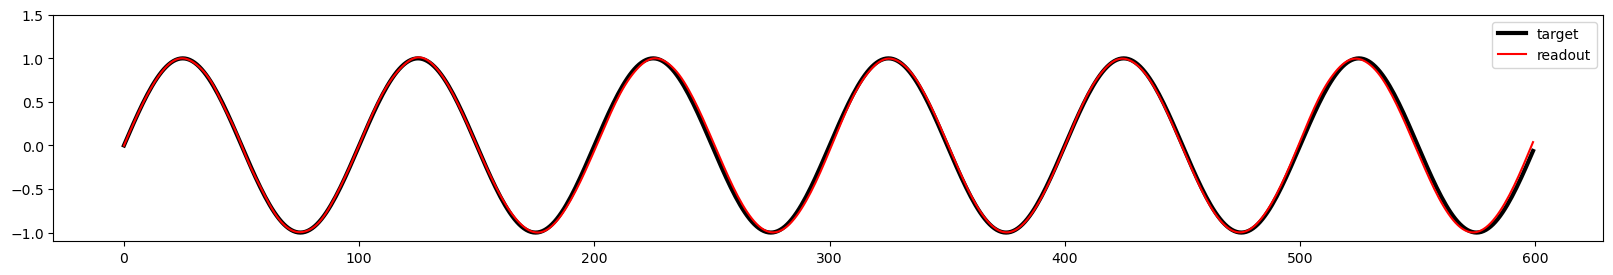

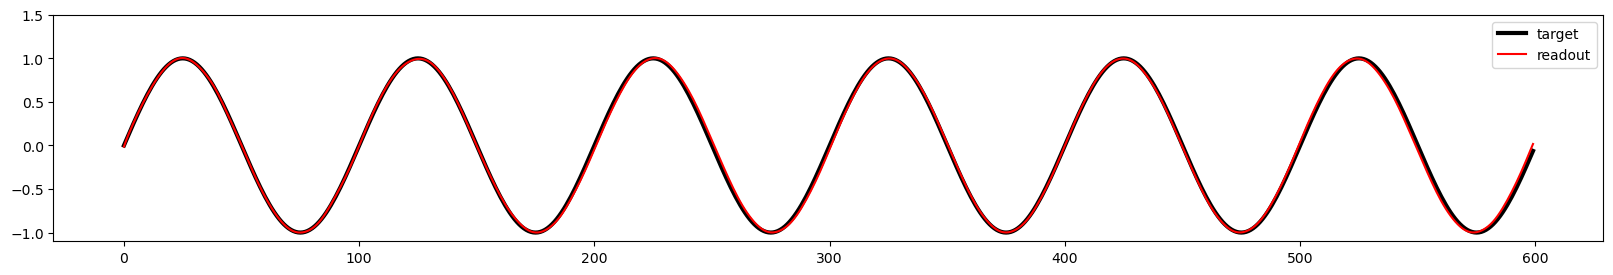

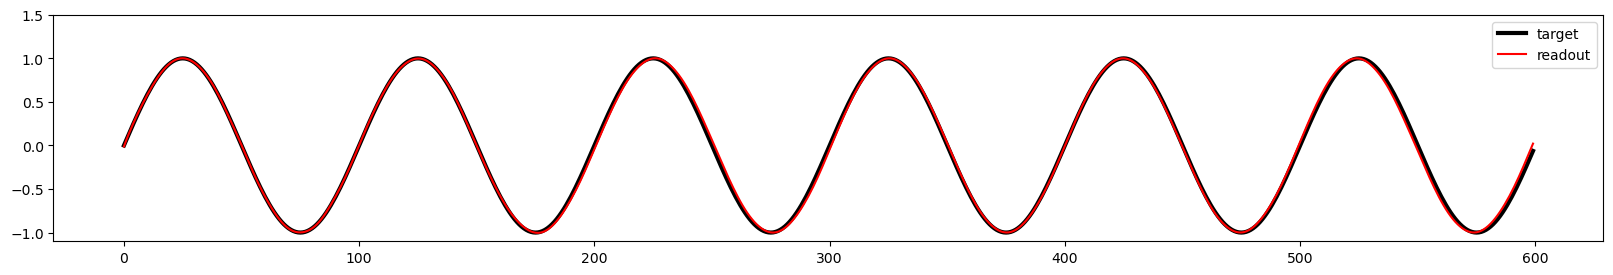

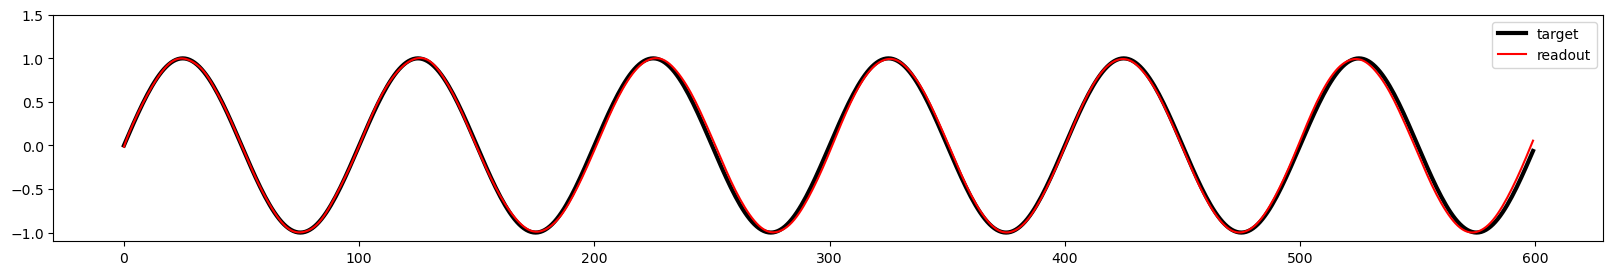

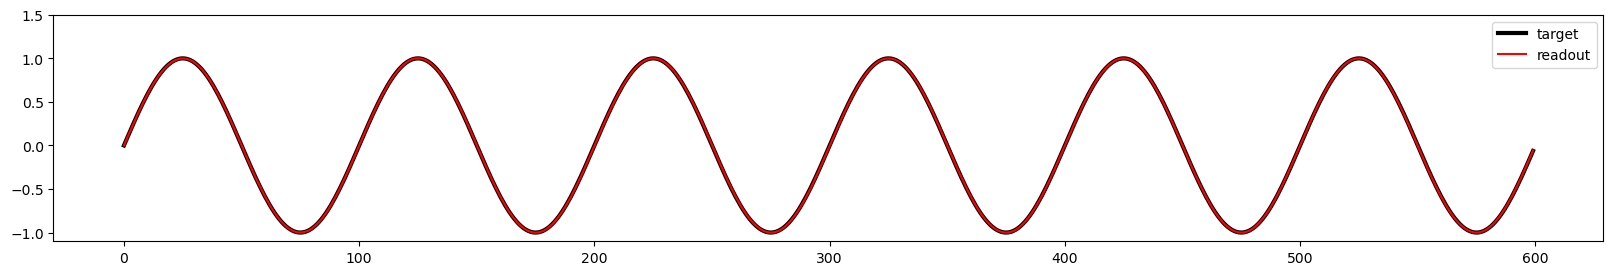

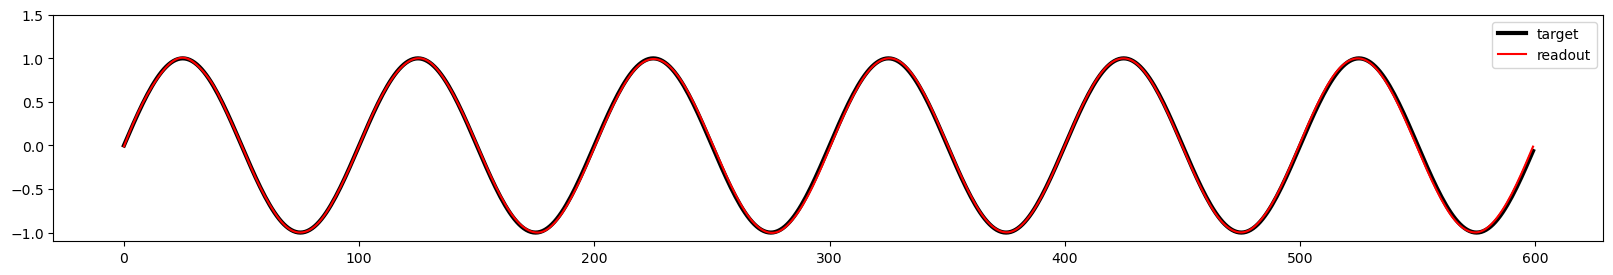

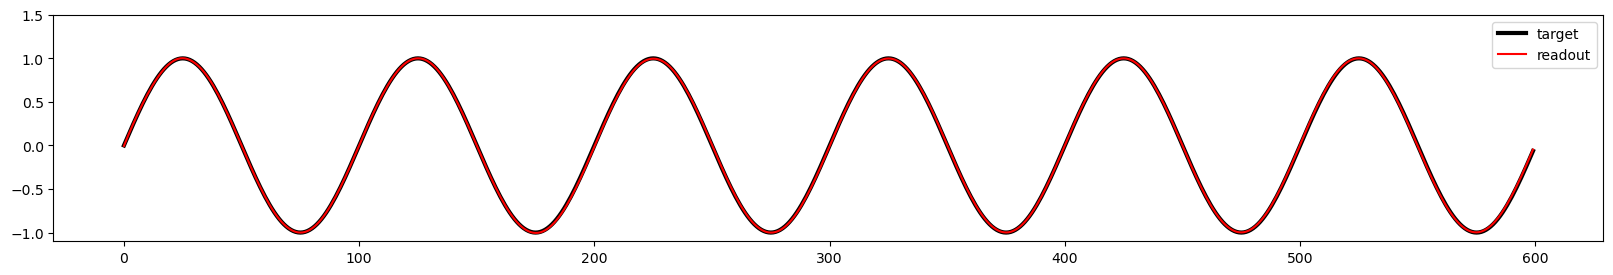

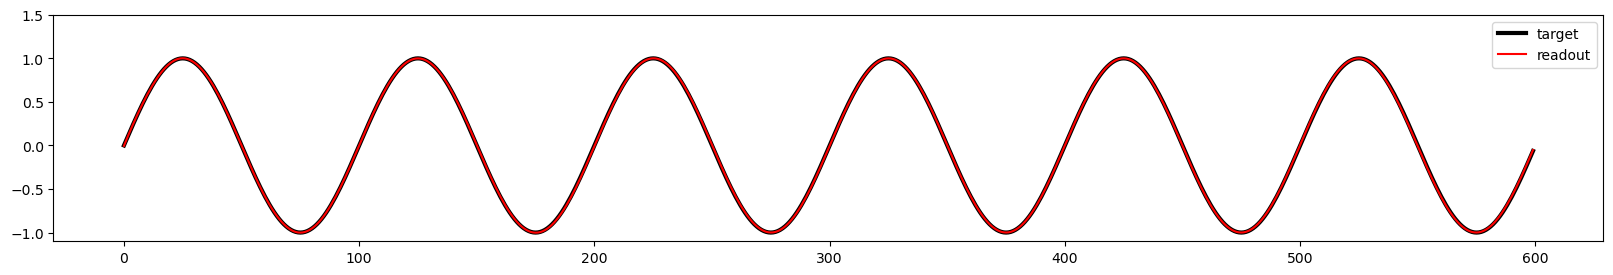

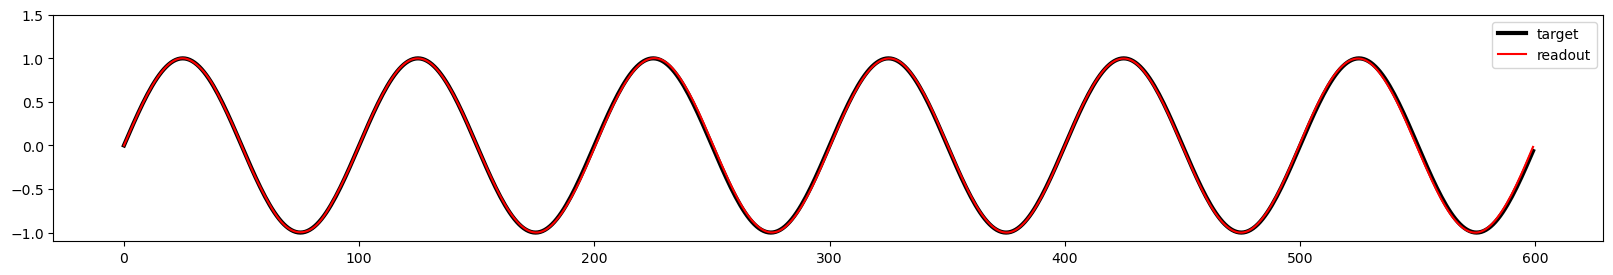

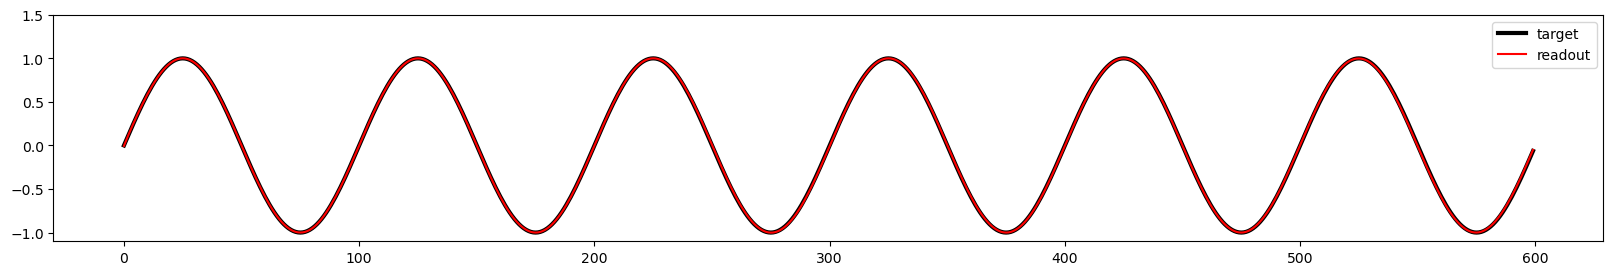

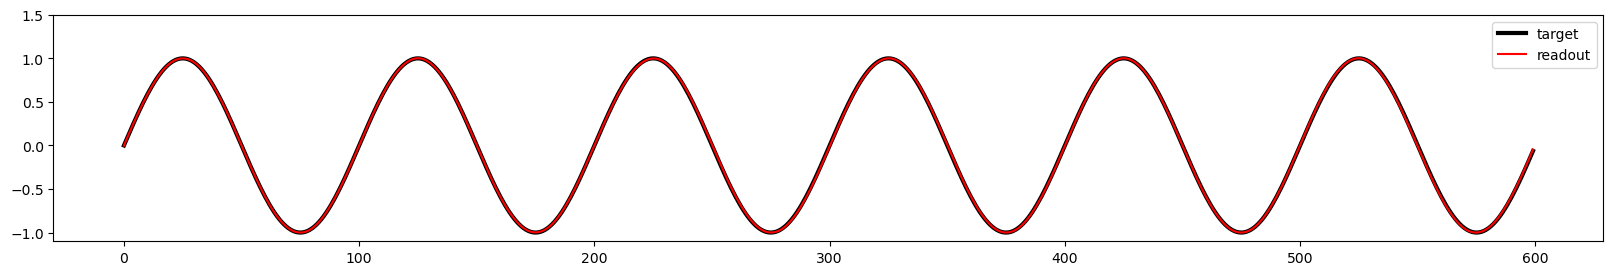

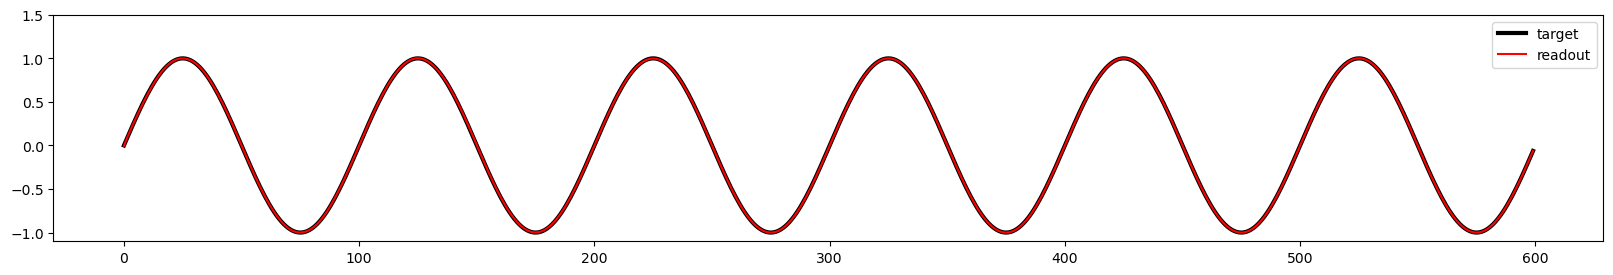

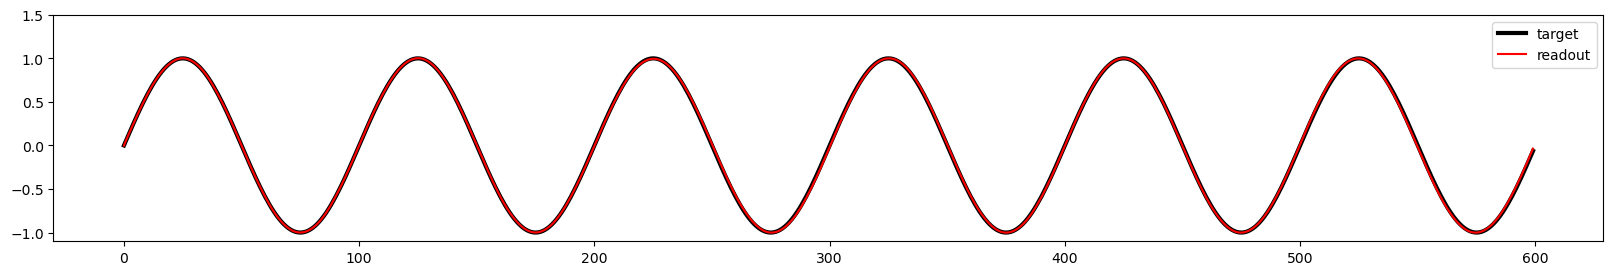

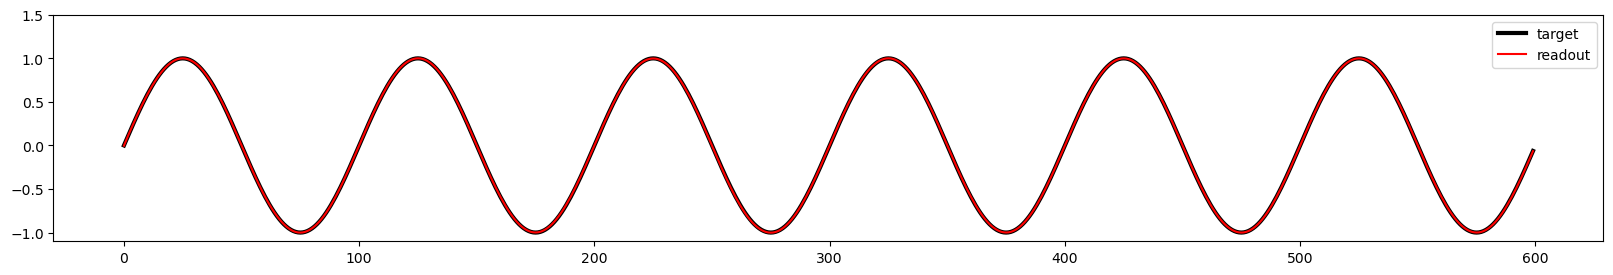

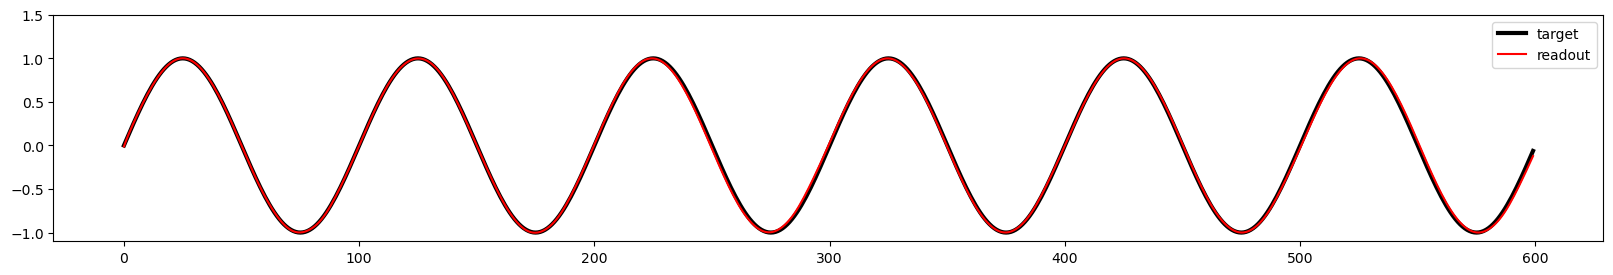

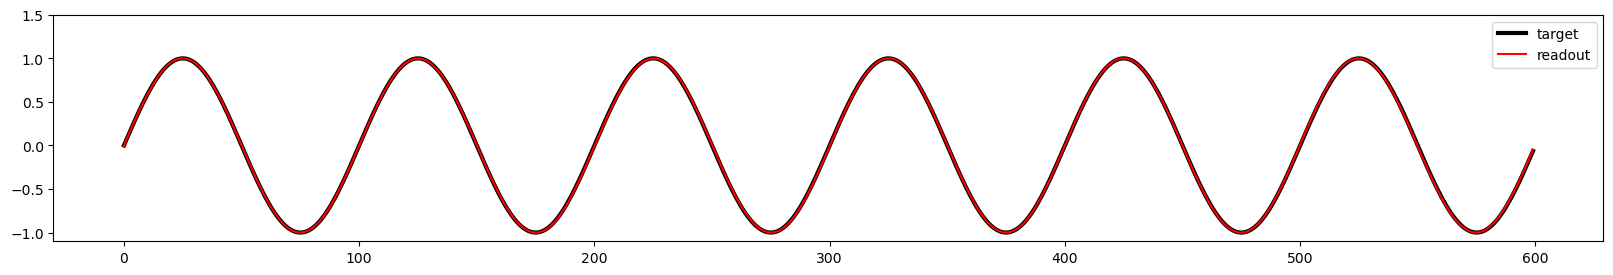

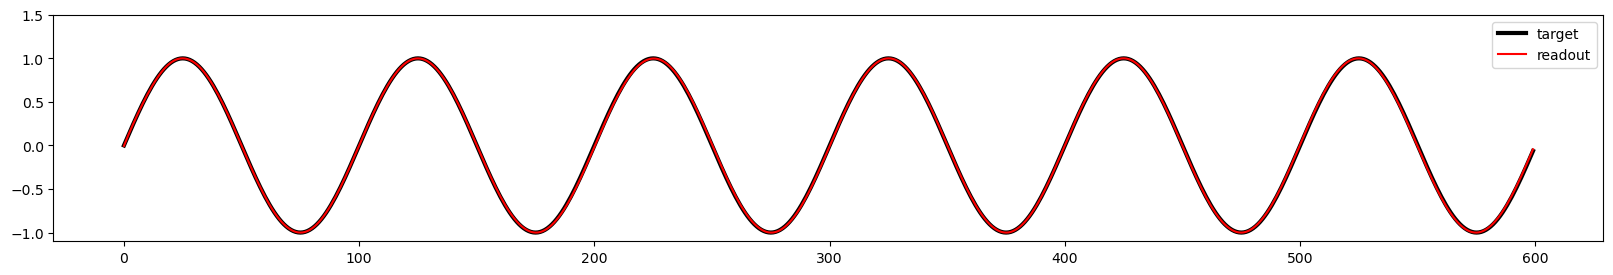

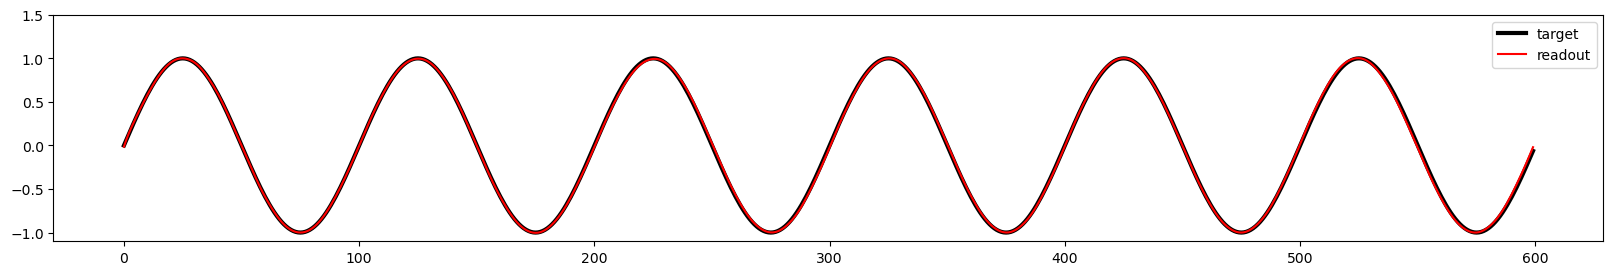

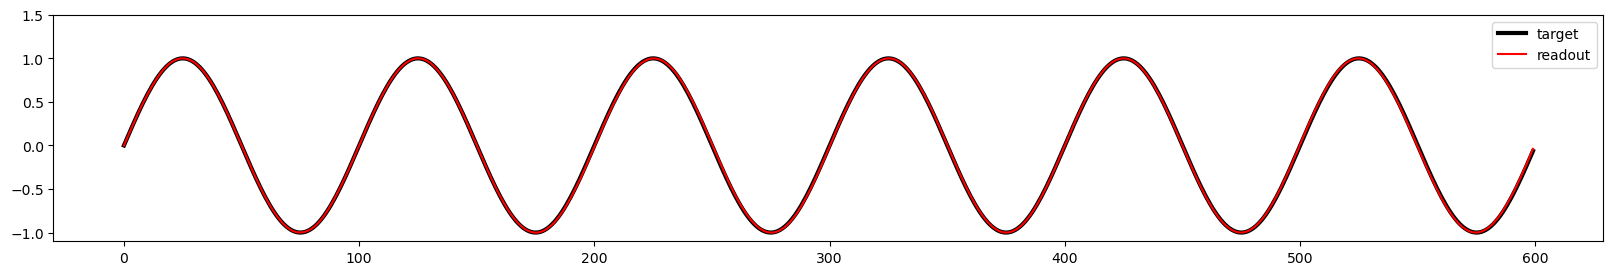

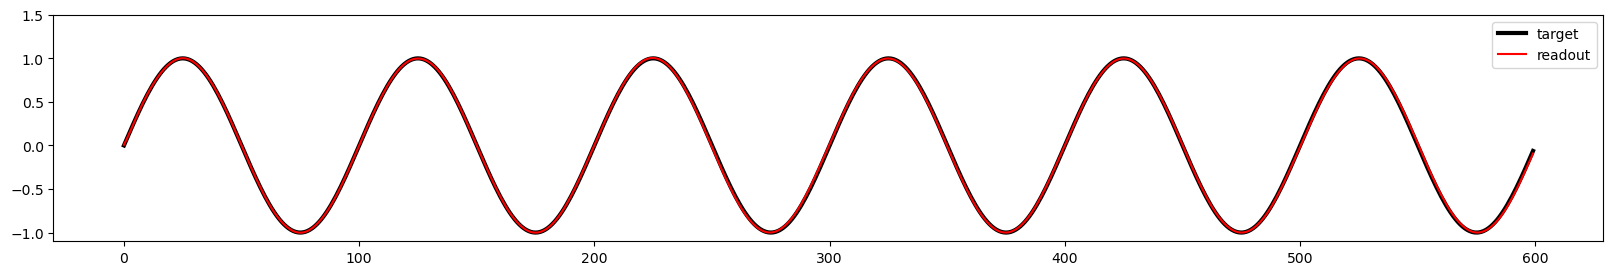

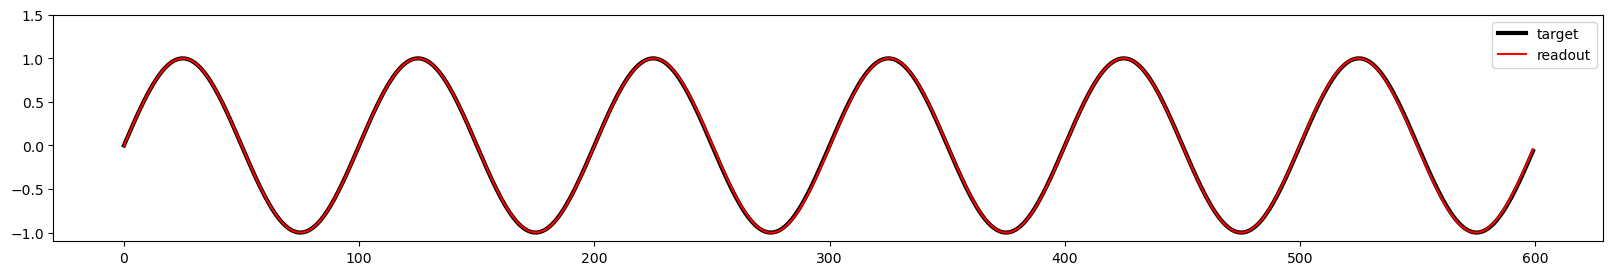

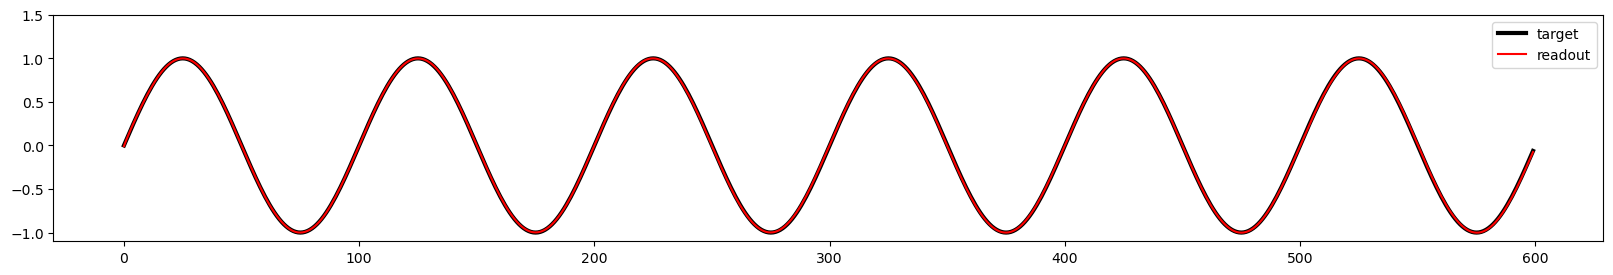

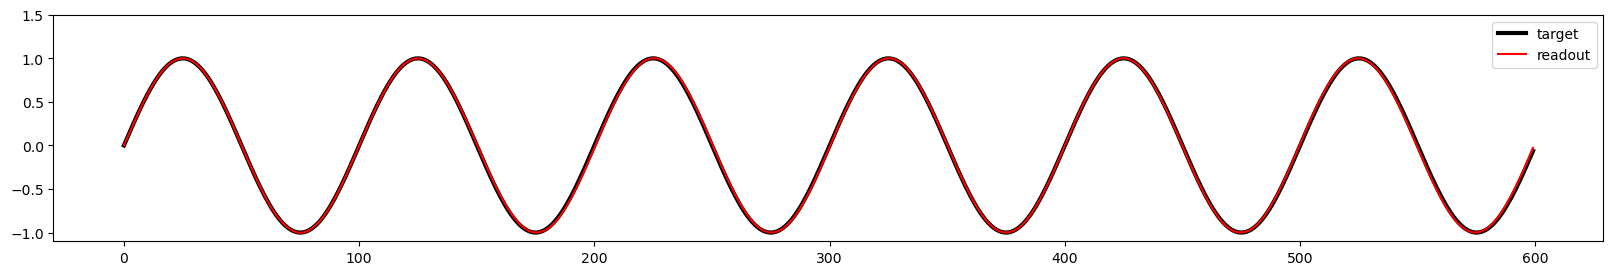

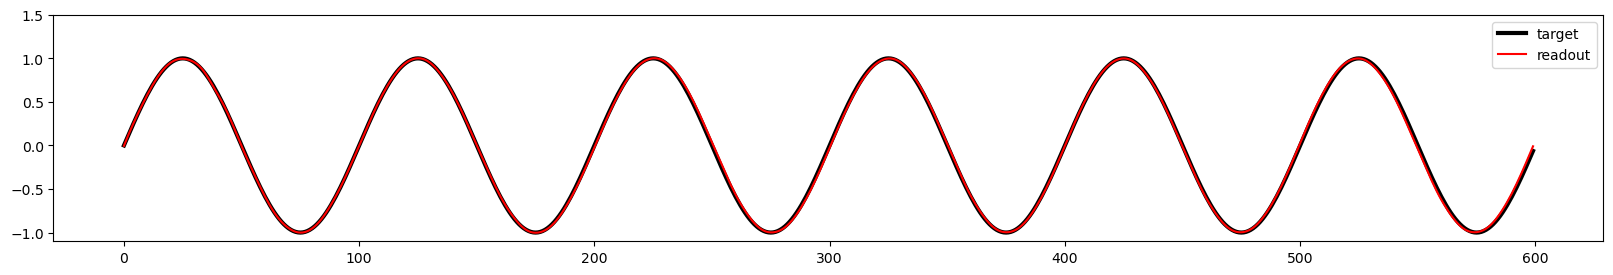

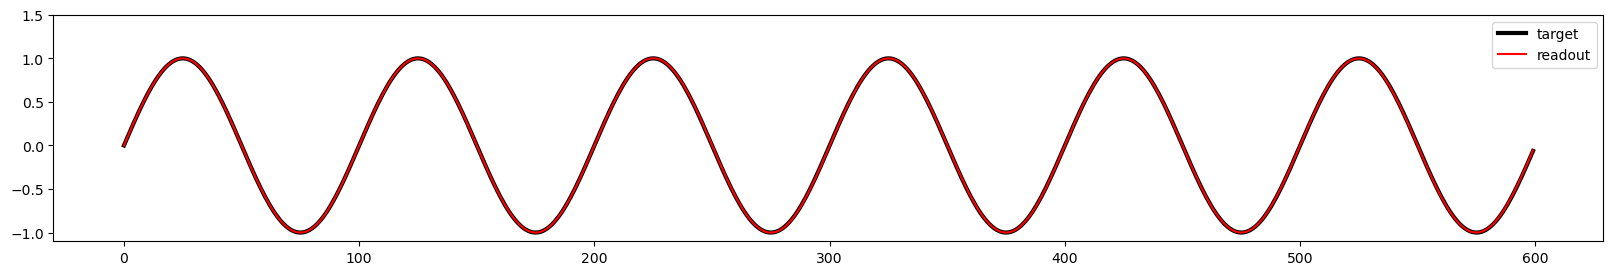

In [98]:
## use regression to define a B for each network ##

# initialize a list for our Bs
B = []

for ii in range(numNetworks):

    # get rates
    rates,z,o = returnRates(u=U[ii],ipt=INPUT[:,0][:,np.newaxis],w=W[ii])

    # reshape to be CT x N
    rates_rs = rates.reshape(-1,numN,order='F');

    # reshape the targets from our rate network
    targets_rs = targets[:,0].reshape(-1,1,order='F')

    # define a regularization term
    ridgeLambda = 1e-4

    # define the null space of W, project rates into this space
    W_null = scipy.linalg.null_space(W[ii].T)
    rates_null = rates_rs@W_null

    # regress
    b_null = np.linalg.inv(rates_null.T @ rates_null + np.eye(rates_null.shape[1]) * ridgeLambda) @ rates_null.T @ targets_rs
    B.append(W_null@b_null)

    # plot target and target_hat
    yHat = rates_rs@B[-1]
    plt.figure(figsize=(20,10))
    plt.subplot(3,1,1);
    plt.plot(targets_rs,'k',linewidth=3,label='target');
    plt.plot(yHat,'r',label='readout');
    plt.ylim([-1.1,1.5]);
    plt.legend();

    # # plot B
    # plt.subplot(3,1,2);
    # plt.plot(B,'b',linewidth=1,label='readout weights');
    # plt.legend();
    #
    # # calculate correlation between B and each column of W
    # plt.subplot(3,1,3);
    # bCorr = np.zeros(numZ) + np.nan
    # for ii in range(numZ):
    #     bCorr[ii] = np.corrcoef(B[:,0],W[:,ii])[0,1]
    # plt.plot(bCorr,'r',linewidth=1,label='correlation between B and W');
    # plt.ylim([-0.1,0.1]);
    # plt.legend();


In [99]:
# save all of the trained weights
# path to saved network
savePath = '/Users/andrew/Documents/GitHub/basal_ganglia/data/stabilityAnalysis/trainedWeights/'

# get current time
ct = str(datetime.datetime.now())[:19]

# replace colons with an underscore
ct = ct.replace(':','_')

# define the save dictionary
dataDict = {'W': W, 'U': U, 'J0': J0, 'W_in': W_in,'B':B,
            'INPUT': INPUT,
            'x0': x0, 'r0': r0,
            'trainingOutputs': outputs,
            'targetProjections': proj}

# save
np.save(savePath + ct + '.npy',dataDict)

### Measure effects of perturbations of U in each model
    - each dU will be random.
    - After applying each dU, I'll renormalize each row of U such that the norm doesn't change.
    - I'm going to use two types of perturbation:
        - first set of perturbation will be drawn from the same distribution, but will have different frobenius norms (because there are different numbers of latents in each model).

In [805]:
# function for returning peak frequency of a 1d Trace
# FFT doesn't give me the resolution I want, so just make a bunch of waves at different frequencies and ask which one matches our signal best

def returnPeakFreq(signal, minFreq = 0.8, maxFreq = 1.2, numFreqs = 500):

    # length of our signal
    L = signal.shape[0]

    # time vector
    t = np.arange(L)

    # vector of frequencies to test
    freqs = np.linspace(minFreq,maxFreq,numFreqs)

    # vector to hold correlations
    rhos = np.zeros(numFreqs) + np.nan

    # cycle through all of our frequencies
    for idx,f in enumerate(freqs):

        # make our templates
        testSin = np.sin(f*0.01 * 2 * np.pi * t)

        rhos[idx] = np.corrcoef(signal,testSin)[0,1]

    # return the frequency that matches best
    return freqs[np.argmax(rhos)]

# function for returning the MSE between two traces, after one has been stretched to match the other.
def calculateAdjustedMSE(signal1, signal2):

    # convert signals to monotonically increasing
    signal1_sum = np.cumsum(signal1+10)
    signal2_sum = np.cumsum(signal2+10)

    # get length of the 'template signal'
    L = signal2_sum.shape[0]

    # find timebase that matches signal 1 to signal 2
    t1 = np.interp(signal1_sum,signal2_sum,np.arange(L))

    # interpolate signal 1 over this timebase
    signal1_sum_interp = np.interp(np.arange(L),t1,signal1_sum)

    # convert back to a sine-like signal
    signal1_interp = np.diff(signal1_sum_interp)
    signal2_diff   = np.diff(signal2_sum)

    # trim the last bit of the signal to avoid weird interpolation errors
    signal1_interp = signal1_interp[:-100]
    signal2_diff = signal2_diff[:-100]


    # now calculate the MSE
    return ((signal1_interp - signal2_diff)**2).mean()

### Run experiment

In [806]:
## parameters ##
# number of perturbations per network
numPerts = 200

# norm range of each perturbation
#
pertMagRange = [1e-3, 5e-2]

# trial duration
trialDur = 5000

# resolution of frequency measurement
freqNumber = 500

# number of networks
numNetworks = len(U)

# initialize array to hold results
dFreq  = np.zeros((numPerts,numNetworks)) + np.nan
MSE = np.zeros((numPerts,numNetworks)) + np.nan

# generate the input
IPT = np.zeros((trialDur,1))+1

# cycle through networks
for NN in range(numNetworks):

    # get the unperturbed output
    _,_,originalOutput = returnRates(u=U[NN],ipt=IPT,w=W[NN],b=B[NN])

    # get the original frequency
    oFreq = returnPeakFreq(originalOut[:,0],minFreq = 0.8, maxFreq = 1.2, numFreqs=freqNumber)

    # norm of the original U weights
    U_norm = np.linalg.norm(U[NN],axis=1)

    # cycle through reps
    for rr in range(numPerts):

        # generate a perturbation matrix for U.
        dU = 2 * np.random.random_sample(size=U[NN].shape) -1

        # choose a perturbation magnitude
        pertMag = np.diff(pertMagRange) * np.random.random_sample() + pertMagRange[0]

        # scale each row of U to have a magnitude of 'pertMag'
        dU = (dU.T/ np.linalg.norm(dU,axis=1)).T
        dU = dU * pertMag

        # generate our perturbed U
        U_pert = U[NN] + dU

        # re-normalize
        U_pert = (U_pert.T / np.linalg.norm(U_pert,axis=1)).T
        U_pert = U_pert * U_norm[:,np.newaxis]

        # generate a perturbed output
        _,_,newOutput = returnRates(u = U_pert,ipt = IPT,w=W[NN],b=B[NN])

        # calculate the new frequency
        nFreq = returnPeakFreq(newOutput[:,0],minFreq = 0.8, maxFreq = 1.2,numFreqs=freqNumber)

        # calculate adjusted MSE
        MSE[rr,NN] = calculateAdjustedMSE(originalOutput[:,0], newOutput[:,0])

        # calculate change in frequency
        dFreq[rr,NN] = nFreq - oFreq


oFreq: 0.9821643286573147
nFreq: 0.9360721442885772
mse: 3.027390019027126e-06


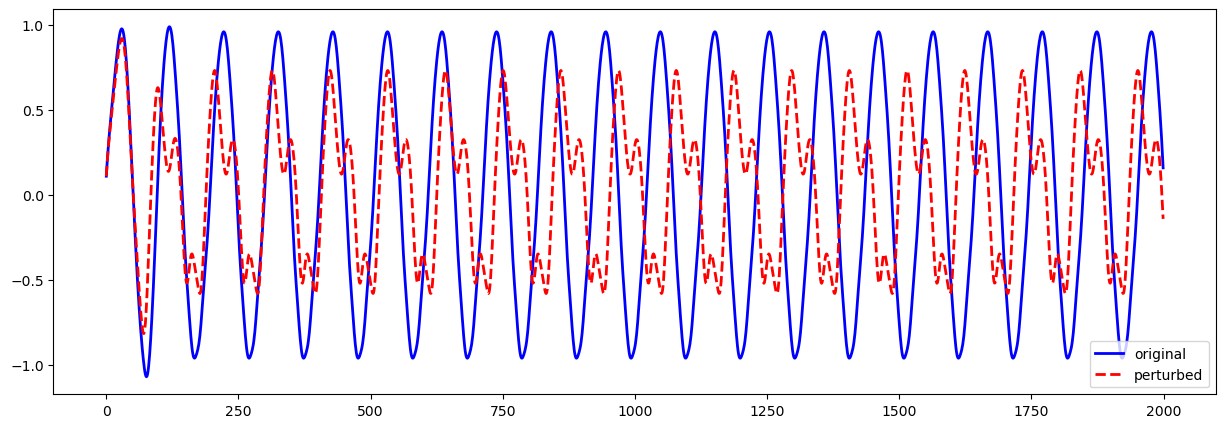

In [819]:
# cycle through networks
NN = 4
IPT = np.zeros((2000,1))+1
freqNumber = 500
pertMag = 5e-2

# get the unperturbed output
_,_,originalOutput = returnRates(u=U[NN],ipt=IPT,w=W[NN],b=B[NN])

plt.figure(figsize=(15,5));
plt.plot(originalOutput, color='b',label='original',linewidth=2);

# get the original frequency
oFreq = returnPeakFreq(originalOut[:,0],minFreq = 0.9, maxFreq = 1.1, numFreqs=freqNumber)

# norm of the original U weights
U_norm = np.linalg.norm(U[NN],axis=1)

# generate a perturbation matrix for U.
dU = 2 * np.random.random_sample(size=U[NN].shape) -1

# scale each row of U to have a magnitude of 'pertMag'
dU = (dU.T/ np.linalg.norm(dU,axis=1)).T
dU = dU * pertMag

# generate our perturbed U
U_pert = U[NN] + dU

# re-normalize
U_pert = (U_pert.T / np.linalg.norm(U_pert,axis=1)).T
U_pert = U_pert * U_norm[:,np.newaxis]

# generate a perturbed output
_,_,newOutput = returnRates(u = U_pert,ipt = IPT,w=W[NN],b=B[NN])
nFreq = returnPeakFreq(newOutput[:,0],minFreq = 0.9, maxFreq = 1.1, numFreqs=freqNumber)

# calculate MSE
mse = calculateAdjustedMSE(originalOutput[:,0], newOutput[:,0])

# display frequency difference
print('oFreq: ' + str(oFreq));
print('nFreq: ' + str(nFreq));
print('mse: ' + str(mse));
plt.plot(newOutput,'r--',label='perturbed',linewidth=2);
plt.legend();

0.00011936163815000294


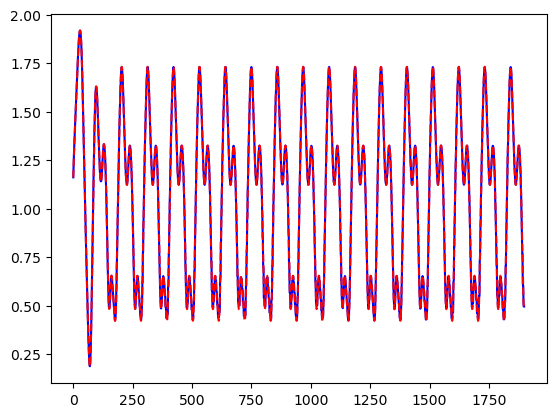

In [831]:
signal1 = originalOutput[:,0]
signal2 = newOutput[:,0]

# convert signals to monotonically increasing
signal1_sum = np.cumsum(signal1+1)
signal2_sum = np.cumsum(signal2+1)

# get length of the 'template signal'
L = signal2_sum.shape[0]

# find timebase that matches signal 1 to signal 2
t1 = np.interp(signal1_sum,signal2_sum,np.arange(L))

# interpolate signal 1 over this timebase
signal1_sum_interp = np.interp(np.arange(L),t1,signal1_sum)

# convert back to a sine-like signal
signal1_interp = np.diff(signal1_sum_interp)
signal2_diff   = np.diff(signal2_sum)

# trim the last bit of the signal to avoid weird interpolation errors
signal1_interp = signal1_interp[:-100]
signal2_diff = signal2_diff[:-100]

print(((signal1_interp - signal2_diff)**2).mean())

plt.plot(signal1_interp,'b');
plt.plot(signal2_diff,'r--');



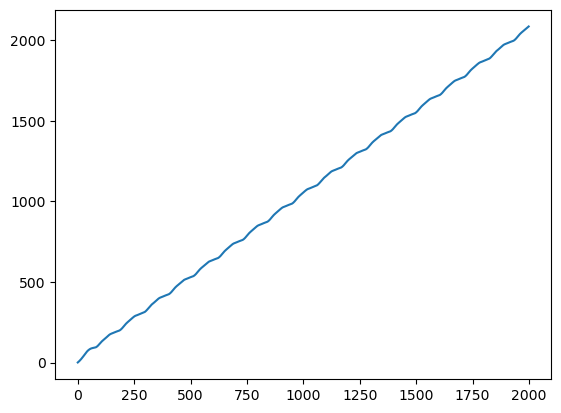

In [832]:
plt.plot(np.cumsum(signal2+1));

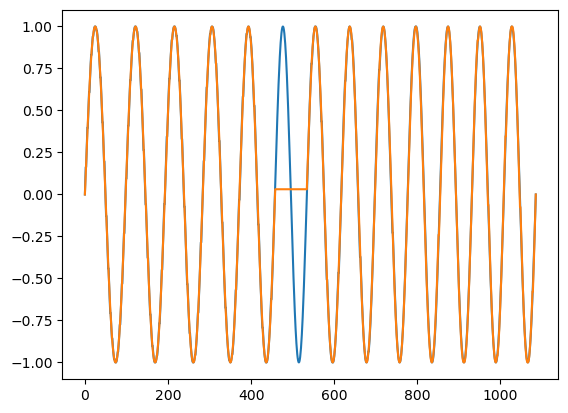

In [860]:
# Define A and B
def A_sin(t):
    return np.sin(2 * np.pi * 1.3 * t)

def B_sin(t, freq):
    return np.sin(2 * np.pi * freq * t)

# Generate time series
T = np.linspace(0, 10, 1000)  # 0 to 10 seconds, sampled at 1000 points
freq_B = np.linspace(1, 1.2, len(T))  # Frequency of B varies between 1 and 1.2 Hz

# Generate signal values
A_values = A_sin(T)
B_values = B_sin(T, freq_B)

# Perform DTW
distance, path = fastdtw(A_values[:,np.newaxis], B_values[:,np.newaxis], dist=euclidean)

# Extract path
indices_A, indices_B = zip(*path)

# Create new time sequences according to the DTW path
T_A_dtw = T[np.array(indices_A)]
T_B_dtw = T[np.array(indices_B)]

interpA = A_sin(T_A_dtw)
interpB = B_sin(T_B_dtw, freq_B[np.array(indices_B)])
plt.plot(interpA)
plt.plot(interpB)

In [859]:
interpA.shape

(1086,)

In [861]:
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

T = np.arange(signal1.shape[0])

# Perform DTW
distance, path = fastdtw(signal1[:,np.newaxis], signal2[:,np.newaxis], dist=euclidean)

# Extract path
indices_A, indices_B = zip(*path)

# Create new time sequences according to the DTW path
T_A_dtw = T[np.array(indices_A)]
T_B_dtw = T[np.array(indices_B)]

# generate new series
signal1_interp = np.interp(T_A_dtw, T, signal1)
signal2_interp = np.interp(T_B_dtw, T, signal2)

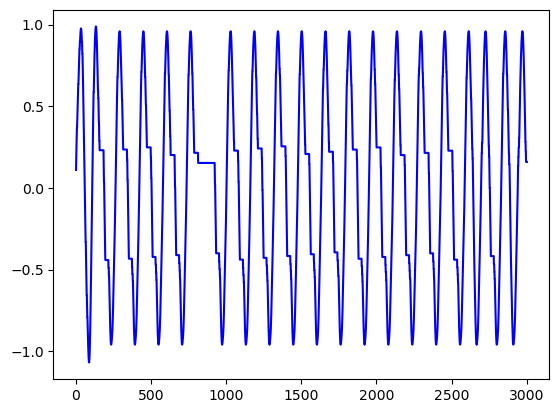

In [863]:
plt.plot(signal1_interp,'b');

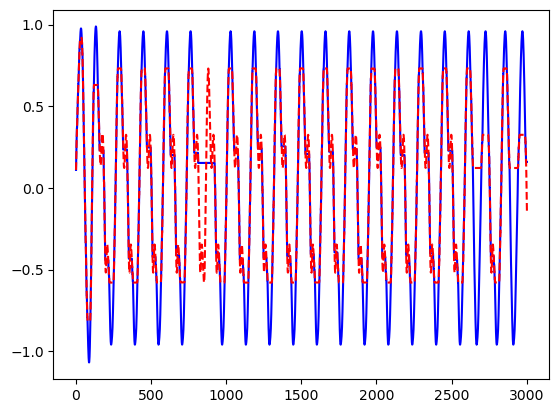

In [862]:
plt.plot(signal1_interp,'b');
plt.plot(signal2_interp,'r--');

### Plot results

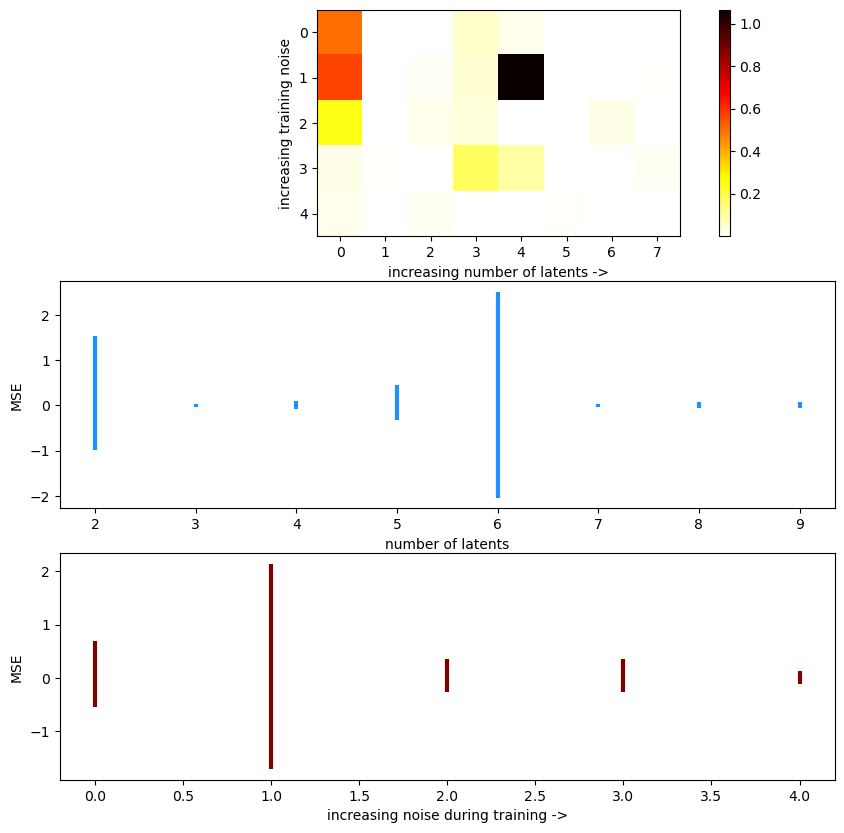

In [812]:
# order results so they're numReps x noiseScale x numZ
numNoiseLevels = len(noiseScale)
MSE_rs   = MSE.reshape(numPerts,numNoiseLevels,-1,order='F')
dFreq_rs = dFreq.reshape(numPerts,numNoiseLevels,-1,order='F')

# number of different number of latents
numDiffZ = dFreq_rs.shape[2]

# set up figure
fig,ax = plt.subplots(3,1,figsize=(10,10));

# plot mean over repetitions
MSE_m = np.mean(MSE_rs,axis=0)
im = ax[0].imshow(MSE_m,cmap='hot_r');
plt.colorbar(im,ax=ax[0]);
ax[0].set_xlabel('increasing number of latents ->');
ax[0].set_ylabel('increasing training noise');


# plot the average MSE as a function of number of latents.
# average over noise levels
MSE_numLatents = MSE_rs.reshape(-1,numDiffZ,order='F')

# plot
MSE_mean = np.mean(MSE_numLatents,axis=0)
MSE_std  = np.std(MSE_numLatents,axis=0)


for jj,kk in enumerate(numZ):
    ax[1].errorbar(kk,MSE_mean[jj],MSE_std[jj],linewidth=3,color='dodgerblue')

# add some labels
ax[1].set_ylabel('MSE');
ax[1].set_xlabel('number of latents');

# average over number of latents
MSE_noiseLevel = MSE_rs.transpose(0,2,1).reshape(-1,numNoiseLevels,order='F')

# plot
MSE_mean = np.mean(MSE_noiseLevel,axis=0)
MSE_std  = np.std(MSE_noiseLevel,axis=0)

for ii in range(numNoiseLevels):
    ax[2].errorbar(ii,MSE_mean[ii],MSE_std[ii],linewidth=3,color='maroon')

# add some labels
ax[2].set_ylabel('MSE');
ax[2].set_xlabel('increasing noise during training ->');

In [ ]:

# function that learns a dU to change the cycling frequency in one context

def runSingleDirectionLearning(IN,w,u,j0,w_in,b,numTrials=10,alpha=1,pertMag=1e-3,ampChangeThreshold = 0.05,targetFreq = 1.8):


    # initialize the U (keep it separate from our original U
    U_learn = np.copy(u)

    # grab the norm of the original U weights
    U_norm = np.linalg.norm(U_learn,axis=1)

    # generate the output for the current U
    _,_,originalOutput = returnRates(u = U_learn,ipt = IN,b=b,w=w,j0=j0,w_in=w_in)

    # current speed
    currentFreq = returnPeakFreq(originalOutput[:,0],minFreq = 1.9, maxFreq = 2.1, numFreqs=100)

    # calculate error between target frequency and current frequency
    error = (targetFreq - currentFreq)**2

    # keep track of our speed in each context
    allError = np.zeros(numTrials)

    # keep track of the amplitude
    allAmp = np.zeros(numTrials)

    # get the amplitude of the current output
    oAmp = np.max(originalOutput[-200:,0])

    # allowed amplitude range (after perturbation)
    maxAmp = oAmp + (oAmp * ampChangeThreshold)
    minAmp = oAmp - (oAmp * ampChangeThreshold)

    # amplitude of current best output
    cAmp = oAmp

    # cycle through trials
    for ii in range(numTrials):

        # generate a perturbation matrix for U.
        dU = 2 * np.random.random_sample(size=U.shape) -1

        # scale each row of U to have a magnitude of 'pertMag'
        dU = (dU.T/ np.linalg.norm(dU,axis=1)).T
        dU = dU * pertMag

        # generate our perturbed U
        U_pert = U_learn + dU

        # re-normalize
        U_pert = (U_pert.T / np.linalg.norm(U_pert,axis=1)).T
        U_pert = U_pert * U_norm[:,np.newaxis]

        # generate a perturbed output
        _,_,newOutput = returnRates(u = U_pert,ipt = IN,b=b,w=w,j0=j0,w_in=w_in)

        # calculate the new frequency
        nFreq = returnPeakFreq(newOutput[:,0],minFreq = currentFreq-0.5, maxFreq = currentFreq+0.5)

        # calculate new error
        nError = (nFreq - targetFreq)**2

        # check that our amplitude hasn't changed too much
        pertAmp = np.max(newOutput[-200:,0])

        # incorporate the change if things got better
        if (nError < error) & (minAmp <= pertAmp <= maxAmp):
            U_learn = np.copy(U_pert)
            error = nError
            currentFreq = np.copy(nFreq)
            cAmp = pertAmp

        # save our error
        allError[ii] = error
        allAmp[ii] = cAmp

    # return error and our learned U
    return U_learn,allError,allAmp

In [ ]:
# function that learns a dU to change the cycling frequency in one context
# learns with an eligibility trace

def runSingleDirectionLearning_elTrace(IN,w,u,j0,w_in,b,numTrials=10,alpha=0.01,pertMag=1e-5,targetFreq = 1.8):

    # initialize the U (keep it separate from our original U
    U_learn = np.copy(u)

    # grab the norm of the original U weights
    U_norm = np.linalg.norm(U_learn,axis=1)

    # generate the output for the current U
    _,_,originalOutput = returnRates(u = U_learn,ipt = IN,b=b,w=w,j0=j0,w_in=w_in)

    # current speed
    currentFreq = returnPeakFreq(originalOutput[:,0],minFreq = 1.9, maxFreq = 2.1, numFreqs=100)

    # calculate error between target frequency and current frequency
    error = (targetFreq - currentFreq)**2

    # keep track of our speed in each context
    allError = np.zeros(numTrials)

    # get the amplitude of the current output
    oAmp = np.max(originalOutput[-200:,0])

    # calculate current error
    error = returnError(tFreq=targetFreq,freq=currentFreq,tAmp=oAmp,amp=oAmp)

    # keep track of dU
    dU_all = np.zeros((U_learn.shape[0],U_learn.shape[1],numTrials))

    # keep track of all of the frequencies
    freqAll = np.zeros(numTrials)

    # keep track of all of the eligibility traces
    elTrace_all = np.zeros((U_learn.shape[0],U_learn.shape[1],numTrials))


    # cycle through trials
    for ii in range(numTrials):

        # generate a perturbation matrix for U.
        uPert = 2 * np.random.random_sample(size=U.shape) -1

        # scale each row of U to have a magnitude of 'pertMag'
        uPert = (uPert.T/ np.linalg.norm(uPert,axis=1)).T
        uPert = uPert * pertMag

        # generate a perturbed output
        rates,latents,newOutput,noPertInput,pertInput = returnRates_separateU(u=U_learn,u_pert=uPert,ipt=IN,w=W,j0=J0,w_in=W_in,b=B)

        # calculate the eligibility trace for each synapse
        elTrace = returnElTrace(pertInput[100:,:,:],noPertInput[100:,:,:])

        # save the eligibility trace
        elTrace_all[:,:,ii] = elTrace[0,:,:].T

        # calculate the new frequency
        nFreq = returnPeakFreq(newOutput[:,0],minFreq = currentFreq-0.5, maxFreq = currentFreq+0.5,numFreqs = 500)
        freqAll[ii] = nFreq

        # calculate the new amplitude
        pertAmp = np.max(np.abs(newOutput[-200:,0]))

        # calculate new error
        nError = returnError(tFreq=targetFreq,freq=nFreq,tAmp=oAmp,amp=pertAmp)

        # only update if things got better
        if (error - nError) > 0:

            # calculate update
            # dU = alpha * (error - nError) * elTrace
            # dU = dU[0,:,:].T * uPert
            dU = uPert * elTrace[0,:,:].T

            # update U_learn
            U_learn += dU

            # re-normalize
            U_learn = (U_learn.T / np.linalg.norm(U_learn,axis=1)).T
            U_learn = U_learn * U_norm[:,np.newaxis]

            # update error
            error = np.copy(nError)
        else:
            dU = np.zeros_like(U)

        # save dU
        dU_all[:,:,ii] = dU

        # save our error
        allError[ii] = error

        # update current frequency
        currentFreq = np.copy(nFreq)

    # return error and our learned U
    return U_learn,allError,dU_all, elTrace_all,freqAll

# return current error (function of output amplitude and output frequency)
def returnError(tFreq,freq, tAmp, amp, freqWeight=1,ampWeight=0.5):

    return freqWeight * ((tFreq - freq)**2) + ampWeight * ((tAmp - amp)**2)

# return the eligibility trace for each synapse
# for now, this is just a threshold
def returnElTrace(pIn,noPIn,tHold=1e-2):


    # each synapse has an eligibility trace
    # the eligibility trace for a given synapse is the dot product of the perturbed (Z * dU) and unperturbed (Z * U) input

    # calculate the product, sum,  and push through supralinear function

    #synProd = (np.sum(pIn * upIn,axis=0))**3

    # mean center the inputs
    noPIn = noPIn - np.mean(noPIn,axis=0)
    pIn = pIn - np.mean(pIn,axis=0)

    synProd = np.sum(noPIn * pIn,axis=0)**3

    # threshold
    thresholdProd = (np.abs(synProd) > tHold).astype('int')

    #  take sum over time, return output
    return thresholdProd

# function for finding scaling of vector A such that the norm of the sum of A and B is equal to C
def find_scaling_factor(A, B, C):
    # Calculate the norms of A and B
    norm_A = np.linalg.norm(A)
    norm_B = np.linalg.norm(B)

    # Calculate the dot product of A and B
    dot_AB = np.dot(A, B)

    # Coefficients for the quadratic equation
    a = norm_A ** 2
    b = 2 * dot_AB
    c = norm_B ** 2 - C ** 2

    # Calculate the discriminant
    discriminant = b ** 2 - 4 * a * c

    # Check if discriminant is negative
    if discriminant < 0:
        return "No real solutions for k"

    # Calculate the two possible values for k
    k1 = (-b + np.sqrt(discriminant)) / (2 * a)
    k2 = (-b - np.sqrt(discriminant)) / (2 * a)

    # only keep the positive value
    k = np.array([k1,k2])
    k = k[k>0]

    return k

In [ ]:
# run the experiment (with the eligibility trace)

# here, we're going to decrease the frequency of the output in context 2 from 2 to 1.8

# define an input
trainingInput = np.zeros((1000,1)) + 2
testingInput  = np.zeros((1000,1)) + 1

# run the experiment
U_learn,allError,dU_all,elTrace_all,freqAll = runSingleDirectionLearning_elTrace(trainingInput,w=W,u=U,j0=J0,w_in=W_in,b=B,numTrials=1000,alpha=1,pertMag=1e-2,targetFreq = 1.5)

# plot results
_,oLatentsTrain,out0_training = returnRates(U,trainingInput,w=W,j0=J0,w_in=W_in,b=B)
_,oLatentsTest,out0_testing = returnRates(U,testingInput,w=W,j0=J0,w_in=W_in,b=B)
_,latentsTrain,outTraining = returnRates(U_learn,trainingInput,w=W,j0=J0,w_in=W_in,b=B)
_,latentsTest,outTesting = returnRates(U_learn,testingInput,w=W,j0=J0,w_in=W_in,b=B)

# calculate final speeds
freq0_training = returnPeakFreq(out0_training[:,0],minFreq = 1.9, maxFreq = 2.1)
freq0_testing = returnPeakFreq(out0_testing[:,0],minFreq = 0.9, maxFreq = 1.1)
freqTraining = returnPeakFreq(outTraining[:,0],minFreq = 1.4, maxFreq = 2.0, numFreqs = 500)
freqTesting = returnPeakFreq(outTesting[:,0],minFreq = 0.5, maxFreq = 1.0, numFreqs = 500)

print('original output (training): ' + str(freq0_training))
print('post-learning output (training): ' + str(freqTraining))

print('original output (testing): ' + str(freq0_testing))
print('post-learning output (testing): ' + str(freqTesting))

# plot error
plt.figure(figsize=(10,12))
plt.subplot(3,1,1);
plt.plot(allError,'crimson',linewidth=2,label='error')
plt.title('error')
plt.xlabel('trials')
plt.legend()

# plot output in the training condition
plt.subplot(3,1,2)

plt.plot(out0_training[:,0],'k',linewidth=2,label='original')
plt.plot(outTraining[:,0],'dodgerblue',linewidth=2,label='post-learning')
plt.ylim([-2,2])
plt.legend()
plt.title('condition with learning');

# plot output in the testing condition
plt.subplot(3,1,3)

plt.plot(out0_testing[:,0],'k',linewidth=2,label='original')
plt.plot(outTesting[:,0],'maroon',linewidth=2,label='post-learning')
plt.ylim([-2,2]);
plt.legend()
plt.title('condition without learning');

In [ ]:
x = np.linalg.norm(dU_all,axis=1)
plt.plot(x[:5,:].T);

In [ ]:
idx = 4
plt.plot(latentsTrain[:,0,idx],'b');
plt.plot(latentsTest[:,0,idx],'r');
plt.plot(oLatentsTrain[:,0,idx],'b--');
plt.plot(oLatentsTest[:,0,idx],'r--');

In [ ]:
y = np.linalg.norm(elTrace_all,axis=1)
plt.plot(y[0:4,:].T);

In [ ]:
plt.plot(x[0,:]);

In [ ]:
U_learn = np.copy(U)
U_norm = np.linalg.norm(U_learn,axis=1)
IN_train = np.zeros((1000,1)) + 2
IN_test = np.zeros((1000,1)) + 1
pertMag = 5e-3

_,_,output0_train = returnRates(u=U_learn,ipt=IN_train,w=W,j0=J0,w_in=W_in,b=B)
_,_,output0_test = returnRates(u=U_learn,ipt=IN_test,w=W,j0=J0,w_in=W_in,b=B)

freq0_train = returnPeakFreq(output0_train,minFreq = 1.7, maxFreq = 2.2)
freq0_test = returnPeakFreq(output0_test,minFreq = 0.7, maxFreq = 1.2)

freq1_train = np.zeros(1000)
freq1_test = np.zeros(1000)

for ii in range(1000):

    U_learn = np.copy(U)

    # generate a perturbation matrix for U.
    U_pert = 2 * np.random.random_sample(size=U.shape) -1

    # scale each row of U to have a magnitude of 'pertMag'
    U_pert = (U_pert.T/ np.linalg.norm(U_pert,axis=1)).T
    U_pert = U_pert * pertMag

    # add to U_learn
    U_learn += U_pert

    # normalize
    U_learn = (U_learn.T / np.linalg.norm(U_learn,axis=1)).T
    U_learn = U_learn * U_norm[:,np.newaxis]

    _,_,output1_train = returnRates(u=U_learn,ipt=IN_train,w=W,j0=J0,w_in=W_in,b=B)
    _,_,output1_test = returnRates(u=U_learn,ipt=IN_test,w=W,j0=J0,w_in=W_in,b=B)

    freq1_train[ii] = returnPeakFreq(output0_train,minFreq = 1.5, maxFreq = 2.5,numFreqs = 500)
    freq1_test[ii] = returnPeakFreq(output0_test,minFreq = 0.7, maxFreq = 1.2,numFreqs = 500)





# rescale U_learn
U_learn = (U_learn.T / np.linalg.norm(U_learn,axis=1)).T
U_learn = U_learn * U_norm[:,np.newaxis]



# generate a perturbed output
_,_,output1_train = returnRates(u=U_learn,ipt=IN_train,w=W,j0=J0,w_in=W_in,b=B)
_,_,output1_test = returnRates(u=U_learn,ipt=IN_test,w=W,j0=J0,w_in=W_in,b=B)

#
# U_new = U_learn + U_pert
#
# U_new = (U_new.T / np.linalg.norm(U_new,axis=1)).T
# U_new = U_new * U_norm[:,np.newaxis]
#
# # generate a perturbed output
# _,_,normOutput = returnRates(u = U_learn + U_pert,ipt = IN,b=B,w=W,j0=J0,w_in=W_in)
#
# # calculate the eligibility trace for each synapse
# elTrace = returnElTrace(rates,pertInput)
#
# # calculate the new frequency
# nFreq = returnPeakFreq(newOutput[:,0],minFreq = 1.7, maxFreq = 2.1)
#
# # calculate the new amplitude
# pertAmp = np.max(newOutput[-200:,0])
#
# # calculate new error
# nError = returnError(tFreq=1.8,freq=nFreq,tAmp=1,amp=pertAmp)
#
# # calculate update
# dU = alpha * (1 - nError) * elTrace
#
# print(nFreq)
# plt.plot(newOutput[:,0]);
# plt.plot(normOutput[:,0]);
plt.figure(figsize=(10,5));
plt.subplot(1,2,1);
plt.plot(output0_train[:,0],'b',label='train pre');
plt.plot(output1_train[:,0],'r',label='train post');
plt.legend();

plt.subplot(1,2,2);
plt.plot(output0_test[:,0],'b',label='test pre');
plt.plot(output1_test[:,0],'r',label='test post');
plt.legend();

In [ ]:
W_pert / np.linalg.norm(W_pert,axis=0)

In [ ]:
W_learn = np.copy(W)
W_norm = np.linalg.norm(W_learn,axis=0)
IN_train = np.zeros((1000,1)) + 2
IN_test = np.zeros((1000,1)) + 1
pertMag = 0.15

_,_,output0_train = returnRates(u=U,ipt=IN_train,w=W_learn,j0=J0,w_in=W_in,b=B)
_,_,output0_test = returnRates(u=U,ipt=IN_test,w=W_learn,j0=J0,w_in=W_in,b=B)

freq0_train = returnPeakFreq(output0_train[:,0],minFreq = 1.7, maxFreq = 2.2)
freq0_test = returnPeakFreq(output0_test[:,0],minFreq = 0.7, maxFreq = 1.2)

freq1_train = np.zeros(1000)
freq1_test = np.zeros(1000)

for ii in range(1000):

    W_learn = np.copy(W)

    # generate a perturbation matrix for U.
    W_pert = 2 * np.random.random_sample(size=W.shape) -1

    # scale each row of U to have a magnitude of 'pertMag'
    W_pert = (W_pert/ np.linalg.norm(W_pert,axis=0))
    W_pert = W_pert * pertMag

    # add to W_learn
    W_learn += W_pert

    # normalize
    W_learn = (W_learn / np.linalg.norm(W_learn,axis=0))
    W_learn = W_learn * W_norm[np.newaxis,:]

    _,_,output1_train = returnRates(u=U,ipt=IN_train,w=W_learn,j0=J0,w_in=W_in,b=B)
    _,_,output1_test = returnRates(u=U,ipt=IN_test,w=W_learn,j0=J0,w_in=W_in,b=B)

    freq1_train[ii] = returnPeakFreq(output1_train[:,0],minFreq = 1.5, maxFreq = 2.5,numFreqs = 500)
    freq1_test[ii] = returnPeakFreq(output1_test[:,0],minFreq = 0.7, maxFreq = 1.2,numFreqs = 500)

In [ ]:
dFreq_train = freq0_train - freq1_train
dFreq_test  = freq0_test - freq1_test

plt.plot(dFreq_train,dFreq_test,'bo');
plt.xlim([-0.05,0.05]);
plt.ylim([-0.05,0.05]);

In [ ]:
dFreq_train = freq0_train - freq1_train
dFreq_test  = freq0_test - freq1_test

plt.plot(dFreq_train,dFreq_test,'bo');
plt.xlim([-0.05,0.05]);
plt.ylim([-0.05,0.05]);

In [ ]:
W_norm

In [ ]:
W_learn = np.copy(W)
W_norm = np.linalg.norm(W_learn,axis=0)
pertMag = 0.5
W_learn = np.copy(W)

# generate a perturbation matrix for U.
W_pert = 2 * np.random.random_sample(size=W.shape) -1

# scale each row of U to have a magnitude of 'pertMag'
W_pert = (W_pert/ np.linalg.norm(W_pert,axis=0))
W_pert = W_pert * pertMag

# add to W_learn
W_learn += W_pert

# normalize
W_learn = (W_learn / np.linalg.norm(W_learn,axis=0))
W_learn = W_learn * W_norm[np.newaxis,:]

_,_,output1_train = returnRates(u=U,ipt=IN_train,w=W_learn,j0=J0,w_in=W_in,b=B)
_,_,output1_test = returnRates(u=U,ipt=IN_test,w=W_learn,j0=J0,w_in=W_in,b=B)


plt.figure(figsize = (10,5))
plt.plot(output0_train,'b');
plt.plot(output0_test,'r');
plt.plot(output1_train,'b--');
plt.plot(output1_test,'r--');

In [ ]:
np.linalg.norm(elTrace**3,axis=0)


In [ ]:
np.linalg.norm(elTrace**3,axis=0)

In [ ]:
np.dot(l[:,0,5,0],r[:,0,0,10])

In [ ]:
plt.plot(l[:,0,5,0])
plt.plot(r[:,0,0,10])

In [ ]:
# run the experiment (no eligibility trace)

# here, we're going to decrease the frequency of the output in context 2 from 2 to 1.8

# define an input
trainingInput = np.zeros((1000,1)) + 2
testingInput  = np.zeros((1000,1)) + 1

# run the experiment
U_learn,allError,allAmp = runSingleDirectionLearning(trainingInput,w=W,u=U,j0=J0,w_in=W_in,b=B,numTrials=400,alpha=1,pertMag=1e-3,ampChangeThreshold = 0.01,targetFreq = 1.8)

# plot results
_,_,out0_training = returnRates(U,trainingInput,w=W,j0=J0,w_in=W_in,b=B)
_,_,out0_testing = returnRates(U,testingInput,w=W,j0=J0,w_in=W_in,b=B)
_,_,outTraining = returnRates(U_learn,trainingInput,w=W,j0=J0,w_in=W_in,b=B)
_,_,outTesting = returnRates(U_learn,testingInput,w=W,j0=J0,w_in=W_in,b=B)

# calculate final speeds
freq0_training = returnPeakFreq(out0_training[:,0],minFreq = 1.9, maxFreq = 2.1)
freq0_testing = returnPeakFreq(out0_testing[:,0],minFreq = 0.9, maxFreq = 1.1)
freqTraining = returnPeakFreq(outTraining[:,0],minFreq = 1.7, maxFreq = 2.0, numFreqs = 500)
freqTesting = returnPeakFreq(outTesting[:,0],minFreq = 0.7, maxFreq = 1.0, numFreqs = 500)

print('original output (training): ' + str(freq0_training))
print('post-learning output (training): ' + str(freqTraining))

print('original output (testing): ' + str(freq0_testing))
print('post-learning output (testing): ' + str(freqTesting))

# plot error
plt.figure(figsize=(10,12))
plt.subplot(3,1,1);
plt.plot(allError,'crimson',linewidth=2,label='error')
plt.title('error')
plt.xlabel('trials')
plt.legend()

# plot output in the training condition
plt.subplot(3,1,2)

plt.plot(out0_training[:,0],'k',linewidth=2,label='original')
plt.plot(outTraining[:,0],'dodgerblue',linewidth=2,label='post-learning')
plt.ylim([-2,2])
plt.legend()
plt.title('condition with learning');

# plot output in the testing condition
plt.subplot(3,1,3)

plt.plot(out0_testing[:,0],'k',linewidth=2,label='original')
plt.plot(outTesting[:,0],'maroon',linewidth=2,label='post-learning')
plt.ylim([-2,2]);
plt.legend()
plt.title('condition without learning');



### When using a static context signal, learning in one context generalizes to the other.
    - This shouldn't happen if the 2 contexts also occur in different sets of dimensions.
    - To probe one extreme, I'll use FORCE to train a Brian network with two sets of W's: one for context 1 and one for context 2.


In [ ]:
###  Train W weights using RLS ###
# fix W_in (taken from the rate model above), choose U randomly

## define a few parameters ##

# network time constant (in msec)
tau = 10

# gain for U weights
g_U = 0.1

# U weights are drawn from a uniform distribution. Set range of this distribution
uMin = -1
uMax = 1

# gain for the input weights
g_W_in = 0.1


# gain for J0 weights. We want these to be fairly small.
g_j0 = 0.5

# gain for initial W weights
g_w  = 0.025

# initial learning rate
alpha = 1

# number of latents
numZ = 10

## draw our U and J0 weights ##

# U first
U = np.random.uniform(low=uMin,high=uMax, size=(numZ*2,numN)) * g_U

# J0
J0 = np.random.normal(loc=0, scale=(g_j0**2)/(numN * tau**2), size=(numN,numN))

# W_in
#W_in = model.Win.detach().numpy()
W_in = np.random.uniform(low=uMin,high=uMax, size=(numN,1)) * g_W_in

## define our target latents, Z ##
Z_target = proj[:,:numZ]

# reshape to be T x C x K
Z_target_rs = Z_target.reshape(-1,numC,numZ,order='F').transpose(0,2,1)

# copy the columns of Z_target_rs
Z_target_rs_double = np.tile(Z_target_rs,(1,2,1))

# for context one, the second K dimensions of the target are just zero
Z_target_rs_double[:,numZ:,0] = 0

# for context two, the first K dimensions are set to 0
Z_target_rs_double[:,:numZ,1] = 0



## rename our inputs ##
INPUT = np.copy(inputs)

## number of trials to train ##
numTrials = 30

## trial duration ##
trlDur = rates.shape[0]

## initialize W ##
W = np.random.normal(loc=0,scale=1/(numN * g_w),size=(numN,numZ*2))

## initial state, x0 ##
x0 = np.random.normal(loc=0, scale=1,size=(numN,1)) / np.sqrt(numN)

## initial rate, r0 ##
r0 = np.zeros((numN,1))

## initial latents, z0 ##
z0 = np.zeros((numZ*2,1))

## initial value of P ##
P = np.eye(numN) / alpha

## scale of the training noise ##
noiseScale = 1e-6


In [ ]:
# cycle through trials

# initialize an array to hold output
networkOutput = np.zeros((trlDur,numZ*2,numC,numTrials))

for trl in range(numTrials):

    # cycle through conditions
    for cc in range(numC):

        # set the initial state, rate, and latent
        x = np.copy(x0)
        r = np.copy(r0)
        z = np.copy(z0)

        # cycle through the trial
        for ii in range(trlDur):

            # update our state
            x += (1/tau) * (-x + (J0.T@r) + (U.T@z) + (INPUT[ii,cc] * W_in)
                            + np.random.normal(loc = 0, scale = np.sqrt(noiseScale), size = x.shape))

            # calculate our current rate
            r = np.tanh(x)

            # calculate the current z
            z = W.T@r

            # save the output
            networkOutput[ii,:,cc,trl] = z[:,0]

            # calculate the error
            error = np.atleast_2d(z[:,0] - Z_target_rs_double[ii,:,cc])

            # update the weights
            W = W - ((P @ r)@error)

            # update P
            P = P - ((P @ r @ r.T @ P)/(1 + (r.T @ P @ r)))


In [ ]:
# plot the first and last trial (along with the target)
numRows = 5
fig, ax = plt.subplots(numRows,4, figsize = (10,15))

# only plot 1 condition
cond = 0

for ii in range(numZ*2):

    # get the row and column index
    rIdx = np.mod(ii,numRows)
    cIdx = (ii//numRows)

    # plot the target
    ax[rIdx,cIdx].plot(Z_target_rs_double[:,ii,cond],'k',linewidth=3,label='target');

    # plot the first trial
    ax[rIdx,cIdx].plot(networkOutput[:,ii,cond,0],'r',linewidth=2,label='first trial')

    # plot the last trial
    ax[rIdx,cIdx].plot(networkOutput[:,ii,cond,-1],'b',linewidth=2,label='last trial')

    # change the y scale
    ax[rIdx,cIdx].set_ylim([-15,15]);


    if ii==0:
        ax[rIdx,cIdx].legend()


In [ ]:
# save the second batch of FORCE weights

# use the same timestamp as above
data_dict = {'J0': J0, 'U': U,'W': W, 'W_in': W_in,
             'x0': x0, 'r0': r0, 'z0': z0,
             'Z_target': Z_target, 'INPUT': INPUT}
np.save(savePath + ct + '_FORCE_network_twoSpaces.npy',data_dict)

In [ ]:
# calculate alignment index between conditions
rates,_,_ = returnRates(U,inputs)
ai = calculateAI(rates[:,0,:].squeeze(),rates[:,1,:].squeeze(),10)
ai_control = calculateAI(rates[:300,0,:].squeeze(),rates[300:,0,:].squeeze(),10)
print('alignment index: ' + str(ai))
print('alignment index within one condition: ' + str(ai_control))

In [ ]:
## use regression to define a B ##

# get rates from the trained FORCE network
rates,latents,_ = returnRates(U,inputs)

# reshape to be CT x N
rates_rs = rates.reshape(-1,numN,order='F');

# reshape the targets from our rate network
targets_rs = targets.reshape(-1,1,order='F')

# define a regularization term
ridgeLambda = 1e-4

# define the null space of W, project rates into this space
W_null = scipy.linalg.null_space(W.T)
rates_null = rates_rs@W_null

# regress
b_null = np.linalg.inv(rates_null.T @ rates_null + np.eye(rates_null.shape[1]) * ridgeLambda) @ rates_null.T @ targets_rs
B = W_null@b_null

# plot target and target_hat
yHat = rates_rs@B
plt.figure(figsize=(20,10))
plt.subplot(3,1,1);
plt.plot(targets_rs,'k',linewidth=3,label='target');
plt.plot(yHat,'r',label='readout');
plt.ylim([-1.1,1.5]);
plt.legend();

# plot B
plt.subplot(3,1,2);
plt.plot(B,'b',linewidth=1,label='readout weights');
plt.legend();

# calculate correlation between B and each column of W
plt.subplot(3,1,3);
bCorr = np.zeros(numZ) + np.nan
for ii in range(numZ):
    bCorr[ii] = np.corrcoef(B[:,0],W[:,ii])[0,1]
plt.plot(bCorr,'r',linewidth=1,label='correlation between B and W');
plt.ylim([-0.1,0.1]);
plt.legend();

In [ ]:
# run the same learning experiment from above (decrease the frequency of the output in context 2 from 2 to 1.8; output in context 1 should not change).

# define an input
trainingInput = np.zeros((1000,1)) + 2
testingInput  = np.zeros((1000,1)) + 1

# run the experiment
U_learn,allError,allAmp = runSingleDirectionLearning(trainingInput,numTrials=400,alpha=1,pertMag=1e-3,ampChangeThreshold = 0.01,targetFreq = 1.8)

# plot results
_,_,out0_training = returnRates(U,trainingInput,B)
_,_,out0_testing = returnRates(U,testingInput,B)
_,_,outTraining = returnRates(U_learn,trainingInput,B)
_,_,outTesting = returnRates(U_learn,testingInput,B)

# calculate final speeds
freq0_training = returnPeakFreq(out0_training[:,0],minFreq = 1.9, maxFreq = 2.1)
freq0_testing = returnPeakFreq(out0_testing[:,0],minFreq = 0.9, maxFreq = 1.1)
freqTraining = returnPeakFreq(outTraining[:,0],minFreq = 1.7, maxFreq = 2.0, numFreqs = 500)
freqTesting = returnPeakFreq(outTesting[:,0],minFreq = 0.7, maxFreq = 1.0, numFreqs = 500)

print('original output (training): ' + str(freq0_training))
print('post-learning output (training): ' + str(freqTraining))

print('original output (testing): ' + str(freq0_testing))
print('post-learning output (testing): ' + str(freqTesting))

# plot error
plt.figure(figsize=(10,12))
plt.subplot(3,1,1);
plt.plot(allError,'crimson',linewidth=2,label='error')
plt.title('error')
plt.xlabel('trials')
plt.legend()

# plot output in the training condition
plt.subplot(3,1,2)

plt.plot(out0_training[:,0],'k',linewidth=2,label='original')
plt.plot(outTraining[:,0],'dodgerblue',linewidth=2,label='post-learning')
plt.ylim([-2,2])
plt.legend()
plt.title('condition with learning');
plt.subplots_adjust(top=1.2)

# plot output in the testing condition
plt.subplot(3,1,3)

plt.plot(out0_testing[:,0],'k',linewidth=2,label='original')
plt.plot(outTesting[:,0],'maroon',linewidth=2,label='post-learning')
plt.ylim([-2,2]);
plt.legend()
plt.title('condition without learning');
plt.subplots_adjust(top=1.2)

# ### Learn two different perturbations to U: one that increases the amplitude of the output and one that decreases the amplitude
    - both will be drawn from B

In [ ]:
# Perturb U with some fraction of B. Absorb changes that reduce error.

def runPertExperiment(out_o,target_2,IN,numTrials=100,alpha=1,pertMag=1e-7):

    # add an axis to our input
    IN = IN[:,np.newaxis]

    # initialize the U (keep it separate from our original U
    U_learn = np.copy(U)

    # generate our current error
    current_e = ((out_original - target2)**2).mean()

    # initialize an array to hold all of our outputs
    trlDur = target2.shape[0]
    output_learn = np.zeros((trlDur,numTrials)) + np.nan

    # keep track of our error
    bestError = np.zeros(numTrials)
    trialError = np.zeros(numTrials)

    # keep track of total perturbation
    totPert = np.zeros(numZ)

    # save all of our Us
    allUs = np.zeros((U_learn.shape[0],U_learn.shape[1],numTrials))

    # save all of the perturbations
    allPerts = np.zeros((numZ,numTrials))

    # cycle through trials
    for ii in range(numTrials):

        # save current U
        allUs[:,:,ii] = U_learn

        # generate a 'numZ' element vector that tells us how much of B to put into U_perturb
        pctB = np.random.normal(loc=0,scale=pertMag,size=(1,numZ))

        # generate our scaled B vectors
        bScaled = B @ pctB

        # generate our perturbed U
        U_pert = U_learn + bScaled.T

        # generate a perturbed output
        _,_,out = returnRates(U_pert,IN,B)

        # calculate new error
        newE = ((out[:,0] - target2)**2).mean()

        # update U_learn if things got better
        if newE < current_e:

            # calculate the percent change in error
            dE = (current_e - newE)/current_e

            # display the change in error
            print(str(dE*100) + ' percent change in error');

            # calculate step size
            step = alpha

            # take a step
            U_learn += (bScaled.T * step)

            # update our current error
            current_e = newE

        # save error
        bestError[ii] = current_e
        trialError[ii]  = newE

    # return error and our learned U
    return U_learn,bestError, trialError


In [ ]:
# rather than choosing perturbations randomly, estimate the gradient by perturbing in a random direction, then taking a step down the gradient
# because we're taking small steps, we should be able to keep an running estimate of the gradient, rather than estimating it from a single perturbation

def runPertExperiment_estGrad(out_o,target_2,IN,numTrials=50,alpha=0.9,pertMag=1e-7):

    # add an axis to our input
    IN = IN[:,np.newaxis]

    # initialize the U (keep it separate from our original U
    U_learn = np.copy(U)

    # generate our current error
    current_e = ((out_original - target2)**2).mean()

    # initialize an array to hold all of our outputs
    trlDur = target2.shape[0]
    output_learn = np.zeros((trlDur,numTrials)) + np.nan

    # keep track of our error
    trialError = np.zeros(numTrials)

    # keep track of total perturbation
    totPert = np.zeros(numZ)

    # save all of our Us
    allUs = np.zeros((U_learn.shape[0],U_learn.shape[1],numTrials))

    # save all of the perturbations
    allPerts = np.zeros((numZ,numTrials))

    # save all of the gradients
    allGradEst = np.zeros((numZ,numTrials))

    # save all of the delta errors
    dE_all = np.zeros(numTrials)

    # cycle through trials
    for ii in range(numTrials):

        # save current U
        allUs[:,:,ii] = U_learn

        # generate a 'numZ' element vector that tells us how much of B to put into U_perturb
        pctB = np.random.normal(loc=0,scale=1,size=numZ)

        # normalize pctB to have a norm of 'pertMag'
        pctB_norm = (pctB/np.linalg.norm(pctB))* pertMag

        # make sure the vector is the right size
        pctB_norm = pctB_norm[np.newaxis,:]

        # generate our scaled B vectors
        bScaled = B @ pctB_norm

        # generate our perturbed U
        U_pert = U_learn + bScaled.T

        # generate a perturbed output
        _,_,out = returnRates(U_pert,IN,B)

        # calculate new error
        newE = ((out[:,0] - target2)**2).mean()

        # calculate change in error
        dE = newE - current_e

        # save change in error
        dE_all[ii] = dE

        # estimate the gradient
        gradEst = dE / pctB_norm

        # save estimate
        allGradEst[:,ii] = gradEst

        # normalize the gradient
        gradEst_norm = (gradEst / np.linalg.norm(gradEst,axis=1))*pertMag

        # take a step in that direction
        step = gradEst_norm * alpha

        # save the perturbation
        totPert += step[0,:]

        # generate the B perturbation
        bStep = B @ step

        # update U
        U_learn -= bStep.T

        # update and save error
        _,_,out = returnRates(U_learn,IN,B)

        # calculate new error
        current_e = ((out[:,0] - target2)**2).mean()
        trialError[ii]  = np.copy(current_e)

    # return error and our learned U
    return U_learn, trialError, allGradEst, totPert, dE_all

In [ ]:

# define our new target
amp2 = 1.5
target2 = np.copy(targets[:,0]) * amp2

# pull out input
IN = inputs[:,0]

#pull our original target
_,_,out_original = returnRates(U,IN[:,np.newaxis],B)


In [ ]:
# test the gradient estimation method

# define our new target
amp2 = 1.5
target2 = np.copy(targets[:,0]) * amp2

# pull out input
IN = inputs[:,0]

#pull our original target
_,_,out_original = returnRates(U,IN[:,np.newaxis],B)

# run experiment
U_l_up_estGrad, trialError_up_estGrad, gradEst_estGrad,totPert,dE_all = runPertExperiment_estGrad(out_original,target2,IN,numTrials=500)


# plot results

# regenerate the output with the current U
_,_,out_final_estGrad = returnRates(U_l_up_estGrad,IN[:,np.newaxis],B)

# plot error
plt.figure(figsize=(8,10))
plt.subplot(2,1,1);
plt.plot(trialError_up_estGrad,'k',linewidth=2,label='trial error');
plt.title('error')
plt.legend()

# plot output
plt.subplot(2,1,2)

# plot original
plt.plot(out_original,'k',linewidth=2,label='original')

# plot target
plt.plot(target2,'r',linewidth=2,label='target')

# plot final output
plt.plot(out_final_estGrad[:,0],'dodgerblue',linewidth=2,label='final output')
plt.ylim([-4,4]);
plt.legend();


In [ ]:
# find perturbation to increase amplitude of output

# define our new target
amp2 = 1.5
target2 = np.copy(targets[:,0]) * amp2

# pull out input
IN = inputs[:,0]

#pull our original target
_,_,out_original = returnRates(U,IN[:,np.newaxis],B)

# run experiment
U_l_up, bestError_up, trialError_up = runPertExperiment(out_original,target2,IN,alpha=1,numTrials=2000,pertMag=1e-7)

# plot results

# regenerate the output with the current U
_,_,out_final_up = returnRates(U_l_up,IN[:,np.newaxis],B)

# plot error
plt.figure(figsize=(8,10))
plt.subplot(2,1,1);
plt.plot(bestError_up,'r',linewidth=2,label='best error')
plt.plot(trialError_up,'k',linewidth=2,label='trial error');
plt.title('error')
plt.legend()

# plot output
plt.subplot(2,1,2)

# plot original
plt.plot(out_original,'k',linewidth=2,label='original')

# plot target
plt.plot(target2,'r',linewidth=2,label='target')

# plot final output
plt.plot(out_final_up,'dodgerblue',linewidth=2,label='final output')
plt.ylim([-4,4]);
plt.legend();


In [ ]:
# find perturbation to decrease amplitude of output

# define our new target
amp2 = 0.5
target2 = np.copy(targets[:,0]) * amp2

# pull out input
IN = inputs[:,0]

#pull our original target
_,_,out_original = returnRates(U,IN[:,np.newaxis],B)

# run experiment
U_l_down, bestError_down, trialError_down = runPertExperiment(out_original,target2,IN,numTrials=1500,pertMag=1e-7)

# regenerate the output with the current U
_,_,out_final_down = returnRates(U_l_down,IN[:,np.newaxis],B)

# plot error
plt.figure(figsize=(8,10))
plt.subplot(2,1,1);
plt.plot(bestError_down,'r',linewidth=2,label='best error')
plt.plot(trialError_down,'k',linewidth=2,label='trial error');
plt.title('error')
plt.legend()

# plot output
plt.subplot(2,1,2)

# plot original
plt.plot(out_original,'k',linewidth=2,label='original')

# plot target
plt.plot(target2,'r',linewidth=2,label='target')

# plot final output
plt.plot(out_final_down,'dodgerblue',linewidth=2,label='final output')
plt.ylim([-4,4]);
plt.legend();


In [ ]:
# see if I can get something a little wonkier

target2 = np.copy(1*targets[:,0] + 1*targets[:,1])

# normalize to a max of 1
target2 = target2 / np.max(target2)

# pull out input
IN = inputs[:,0]

#pull our original target
_,_,out_original = returnRates(U,IN[:,np.newaxis],B)

# run experiment
U_l_wonky, bestError_wonky, trialError_wonky = runPertExperiment(out_original,target2,IN,numTrials=6000,pertMag=1e-7)

# regenerate the output with the current U
_,_,out_final_wonky = returnRates(U_l_wonky,IN[:,np.newaxis],B)

# plot error
plt.figure(figsize=(8,10))
plt.subplot(2,1,1);
plt.plot(bestError_wonky,'r',linewidth=2,label='best error')
plt.plot(trialError_wonky,'k',linewidth=2,label='trial error');
plt.title('error')
plt.legend()

# plot output
plt.subplot(2,1,2)

# plot original
plt.plot(out_original,'k',linewidth=2,label='original')

# plot target
plt.plot(target2,'r',linewidth=2,label='target')

# plot final output
plt.plot(out_final_wonky,'dodgerblue',linewidth=2,label='final output')
plt.ylim([-4,4]);
plt.legend();

In [ ]:
# generate latents for each of these learned U perturbations

# put everything in a list to make life easy
U_perts = [U_l_up, U_l_down, U_l_wonky]

# initialize a list to hold latents
perturbedLatents = []

# cycle through perturbations
for ii in range(3):

    # grab our input
    IN = inputs[:,1]

    # regenerate the output
    _,tempLats,_ = returnRates(U_perts[ii],IN[:,np.newaxis],B)

    # add to list
    perturbedLatents.append(tempLats)

# cycle through all of the latents and plot

# plot the first and last trial (along with the target)
fig, ax = plt.subplots(5,4, figsize = (15,15))

# define some colors
colors = ['dodgerblue','crimson','darkorchid']
labels = ['amp. up','amp. down','wonky']
lineWidths = [8,4,1]

for ii in range(numZ):

    # get the row and column index
    rIdx = np.mod(ii,5)
    cIdx = (ii//5)

    # cycle through latents
    for jj in range(3):

        # plot
        ax[rIdx,cIdx].plot(perturbedLatents[jj][:,0,ii],color = colors[jj],linewidth=lineWidths[jj],label=labels[jj]);

    # change the y scale
    ax[rIdx,cIdx].set_ylim([-15,15]);

    # add a title
    ax[rIdx,cIdx].set_title('latent ' + str(ii))

    if ii==0:
        ax[rIdx,cIdx].legend()

In [ ]:
# plot a few example units

# put everything in a list to make life easy
U_perts = [U_l_up, U_l_down, U_l_wonky]

# initialize a list to hold latents
perturbedRates = []
perturbedOutput = []

# cycle through perturbations
for ii in range(3):

    # grab our input
    IN = inputs[:,1]

    # regenerate the output
    tempRates,_,output = returnRates(U_perts[ii],IN[:,np.newaxis],B)

    # add to list
    perturbedRates.append(tempRates)
    perturbedOutput.append(output)

#cycle through the first 10 units and plot

# plot the first and last trial (along with the target)
fig, ax = plt.subplots(5,4, figsize = (15,15))

# choose 10 random neurons to plot
randIdx = np.random.choice(numN,size=numZ,replace=False)

# define some colors
colors = ['dodgerblue','crimson','darkorchid']
labels = ['amp. up','amp. down','wonky']
lineWidths = [1,1,1]

for ii in range(numZ):

    # get the row and column index
    rIdx = np.mod(ii,5)
    cIdx = (ii//5)

    # cycle through latents
    for jj in range(3):

        # plot
        ax[rIdx,cIdx].plot(perturbedRates[jj][:,0,randIdx[ii]],color = colors[jj],linewidth=lineWidths[jj],label=labels[jj]);

    # change the y scale
    ax[rIdx,cIdx].set_ylim([-1.5,1.5]);

    # add a title
    ax[rIdx,cIdx].set_title('latent ' + str(ii))

    if ii==0:
        ax[rIdx,cIdx].legend()